# Characterization of ALPACA's modules

In [651]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

## Preparation
First we read the membership file from ALPACA, the two networks, and we prepare the data

In [652]:
# Output directory
import os
outputDir = "../results/alpaca-batch-coad-subtype-connnectivity-20250317/"
if not os.path.exists(outputDir):
    os.makedirs(outputDir)
# ALPACA membership file
membership_fn = "../data/processed/alpaca-batch-coad-subtype-20240510/membership_csm2_csm4.csv"
# Read membership
membership = pd.read_csv(membership_fn)
membership.head()


node  module  modularity
0   ALX1_A       1    0.006097
1   ALX3_A       2    0.011064
2   ALX4_A       1    0.005248
3     AR_A       2    0.001445
4  ARGFX_A       2    0.012254

In [653]:
# clean membership table splitting node into node_name and node_type
membership['node_name'] = membership.node.str.split('_').str[0]
membership['node_type'] = membership.node.str.split('_').str[1]
membership.head()


node  module  modularity node_name node_type
0   ALX1_A       1    0.006097      ALX1         A
1   ALX3_A       2    0.011064      ALX3         A
2   ALX4_A       1    0.005248      ALX4         A
3     AR_A       2    0.001445        AR         A
4  ARGFX_A       2    0.012254     ARGFX         A

In [655]:
# map the genes with gencode
gencode = '../data/external/gen_v26_mapping.csv'
gencode = pd.read_csv(gencode, sep=',')
ens2symbol = gencode.set_index('gene_id')['gene_name'].to_dict()
ens2symbol = {k.split('.')[0]: v for k, v in ens2symbol.items()}
membership['gene_symbol'] = [ens2symbol[i] if i.startswith('ENSG') else i for i in membership['node_name']]
membership

node  module  modularity        node_name node_type  \
0                 ALX1_A       1    0.006097             ALX1         A   
1                 ALX3_A       2    0.011064             ALX3         A   
2                 ALX4_A       1    0.005248             ALX4         A   
3                   AR_A       2    0.001445               AR         A   
4                ARGFX_A       2    0.012254            ARGFX         A   
...                  ...     ...         ...              ...       ...   
20641  ENSG00000253451_B       8    0.000065  ENSG00000253451         B   
20642  ENSG00000278020_B       8    0.000120  ENSG00000278020         B   
20643  ENSG00000148926_B       1    0.000090  ENSG00000148926         B   
20644  ENSG00000146477_B       4    0.000040  ENSG00000146477         B   
20645  ENSG00000273329_B       8   -0.000012  ENSG00000273329         B   

         gene_symbol  
0               ALX1  
1               ALX3  
2               ALX4  
3                 AR  
4              ARGFX  
...              ...  
20641       IGLV2-28  
20642   HOXA11-AS1_6  
20643            ADM  
20644        SLC22A3  
20645  RP11-448A19.1  

[20646 rows x 6 columns]

## Analysis of PANDA connectivity

Here, using the modules identified by ALPACA, we check the differences in connectivity between the two subtypes

In [168]:
# read the two networks
cms2_net = pd.read_csv("../data/processed/batch-coad-subtype-20240510/tcga_coad_cms2/analysis/panda/panda_tcga_coad_cms2.txt", sep=" ", index_col=0)
cms4_net = pd.read_csv("../data/processed/batch-coad-subtype-20240510/tcga_coad_cms4/analysis/panda/panda_tcga_coad_cms4.txt", sep=" ", index_col=0)

In [656]:
# read the two networks
cms2_net = pd.read_csv("../../tcga-coad-subtype/results/batch-coad-subtype-20240510/tcga_coad_cms2/analysis/panda/panda_tcga_coad_cms2.txt", sep=" ", index_col=0)
cms4_net = pd.read_csv("../../tcga-coad-subtype/results/batch-coad-subtype-20240510/tcga_coad_cms4/analysis/panda/panda_tcga_coad_cms4.txt", sep=" ", index_col=0)

### Prepare an edge membership table

In [657]:
# melt the dataframe and keep the index
cms2_long = cms2_net.melt(ignore_index = False, var_name = 'gene', value_name='cms2').reset_index()
cms4_long = cms4_net.melt(ignore_index = False, var_name = 'gene', value_name='cms4').reset_index()

In [658]:
# Get the two nets
nets = cms2_long.merge(cms4_long, on =['tf','gene'], how = 'inner')
nets.shape

(19590053, 4)

In [659]:
nets.head()

tf             gene      cms2      cms4
0   ALX1  ENSG00000000003  1.639950  0.701865
1   ALX3  ENSG00000000003  0.463252  0.087116
2   ALX4  ENSG00000000003  1.347992  0.552226
3     AR  ENSG00000000003 -0.986745 -0.862890
4  ARGFX  ENSG00000000003  0.887296  0.290060

In [660]:
# In this table we report each edge (tf-gene) , the CMS2 and CMS4 values and the membership of the gene and the tf
edge_membership = nets.merge(membership, left_on='gene', right_on='node_name', how = 'left')
edge_membership = edge_membership.merge(membership, left_on='tf', right_on='node_name', how = 'left', suffixes=('_gene', '_tf'))
edge_membership.head()

tf             gene      cms2      cms4          node_gene  module_gene  \
0   ALX1  ENSG00000000003  1.639950  0.701865  ENSG00000000003_B            7   
1   ALX3  ENSG00000000003  0.463252  0.087116  ENSG00000000003_B            7   
2   ALX4  ENSG00000000003  1.347992  0.552226  ENSG00000000003_B            7   
3     AR  ENSG00000000003 -0.986745 -0.862890  ENSG00000000003_B            7   
4  ARGFX  ENSG00000000003  0.887296  0.290060  ENSG00000000003_B            7   

   modularity_gene   node_name_gene node_type_gene gene_symbol_gene  node_tf  \
0         0.002225  ENSG00000000003              B           TSPAN6   ALX1_A   
1         0.002225  ENSG00000000003              B           TSPAN6   ALX3_A   
2         0.002225  ENSG00000000003              B           TSPAN6   ALX4_A   
3         0.002225  ENSG00000000003              B           TSPAN6     AR_A   
4         0.002225  ENSG00000000003              B           TSPAN6  ARGFX_A   

   module_tf  modularity_tf node_name_tf node_type_tf gene_symbol_tf  
0          1       0.006097         ALX1            A           ALX1  
1          2       0.011064         ALX3            A           ALX3  
2          1       0.005248         ALX4            A           ALX4  
3          2       0.001445           AR            A             AR  
4          2       0.012254        ARGFX            A          ARGFX

In [661]:
# For each edge, check if TF-gene are in the same module
edge_membership['same_module'] = edge_membership.module_gene == edge_membership.module_tf
edge_membership['edge_module'] = edge_membership['same_module'].astype(int) * edge_membership['module_gene'].astype(int)
edge_membership

tf             gene      cms2      cms4          node_gene  \
0            ALX1  ENSG00000000003  1.639950  0.701865  ENSG00000000003_B   
1            ALX3  ENSG00000000003  0.463252  0.087116  ENSG00000000003_B   
2            ALX4  ENSG00000000003  1.347992  0.552226  ENSG00000000003_B   
3              AR  ENSG00000000003 -0.986745 -0.862890  ENSG00000000003_B   
4           ARGFX  ENSG00000000003  0.887296  0.290060  ENSG00000000003_B   
...           ...              ...       ...       ...                ...   
19590048   ZSCAN4  ENSG00000284594 -0.292792 -0.106729  ENSG00000284594_B   
19590049   ZSCAN5  ENSG00000284594  0.836854  0.792892  ENSG00000284594_B   
19590050  ZSCAN5C  ENSG00000284594 -0.752496 -0.782719  ENSG00000284594_B   
19590051   ZSCAN9  ENSG00000284594 -1.703456 -1.760072  ENSG00000284594_B   
19590052     ZZZ3  ENSG00000284594 -1.147959 -1.203783  ENSG00000284594_B   

          module_gene  modularity_gene   node_name_gene node_type_gene  \
0                   7         0.002225  ENSG00000000003              B   
1                   7         0.002225  ENSG00000000003              B   
2                   7         0.002225  ENSG00000000003              B   
3                   7         0.002225  ENSG00000000003              B   
4                   7         0.002225  ENSG00000000003              B   
...               ...              ...              ...            ...   
19590048            2         0.000089  ENSG00000284594              B   
19590049            2         0.000089  ENSG00000284594              B   
19590050            2         0.000089  ENSG00000284594              B   
19590051            2         0.000089  ENSG00000284594              B   
19590052            2         0.000089  ENSG00000284594              B   

         gene_symbol_gene    node_tf  module_tf  modularity_tf node_name_tf  \
0                  TSPAN6     ALX1_A          1       0.006097         ALX1   
1                  TSPAN6     ALX3_A          2       0.011064         ALX3   
2                  TSPAN6     ALX4_A          1       0.005248         ALX4   
3                  TSPAN6       AR_A          2       0.001445           AR   
4                  TSPAN6    ARGFX_A          2       0.012254        ARGFX   
...                   ...        ...        ...            ...          ...   
19590048          MIR7847   ZSCAN4_A          2       0.002642       ZSCAN4   
19590049          MIR7847   ZSCAN5_A          4       0.002277       ZSCAN5   
19590050          MIR7847  ZSCAN5C_A          4       0.000994      ZSCAN5C   
19590051          MIR7847   ZSCAN9_A          1       0.002776       ZSCAN9   
19590052          MIR7847     ZZZ3_A          1       0.001415         ZZZ3   

         node_type_tf gene_symbol_tf  same_module  edge_module  
0                   A           ALX1        False            0  
1                   A           ALX3        False            0  
2                   A           ALX4        False            0  
3                   A             AR        False            0  
4                   A          ARGFX        False            0  
...               ...            ...          ...          ...  
19590048            A         ZSCAN4         True            2  
19590049            A         ZSCAN5        False            0  
19590050            A        ZSCAN5C        False            0  
19590051            A         ZSCAN9        False            0  
19590052            A           ZZZ3        False            0  

[19590053 rows x 18 columns]

In [662]:
# Compute the edge difference and absolute edge difference
edge_membership['diff_edge'] = edge_membership['cms2'] - edge_membership['cms4']
edge_membership['diff_edge_abs'] = abs(edge_membership['diff_edge'])
edge_membership

tf             gene      cms2      cms4          node_gene  \
0            ALX1  ENSG00000000003  1.639950  0.701865  ENSG00000000003_B   
1            ALX3  ENSG00000000003  0.463252  0.087116  ENSG00000000003_B   
2            ALX4  ENSG00000000003  1.347992  0.552226  ENSG00000000003_B   
3              AR  ENSG00000000003 -0.986745 -0.862890  ENSG00000000003_B   
4           ARGFX  ENSG00000000003  0.887296  0.290060  ENSG00000000003_B   
...           ...              ...       ...       ...                ...   
19590048   ZSCAN4  ENSG00000284594 -0.292792 -0.106729  ENSG00000284594_B   
19590049   ZSCAN5  ENSG00000284594  0.836854  0.792892  ENSG00000284594_B   
19590050  ZSCAN5C  ENSG00000284594 -0.752496 -0.782719  ENSG00000284594_B   
19590051   ZSCAN9  ENSG00000284594 -1.703456 -1.760072  ENSG00000284594_B   
19590052     ZZZ3  ENSG00000284594 -1.147959 -1.203783  ENSG00000284594_B   

          module_gene  modularity_gene   node_name_gene node_type_gene  \
0                   7         0.002225  ENSG00000000003              B   
1                   7         0.002225  ENSG00000000003              B   
2                   7         0.002225  ENSG00000000003              B   
3                   7         0.002225  ENSG00000000003              B   
4                   7         0.002225  ENSG00000000003              B   
...               ...              ...              ...            ...   
19590048            2         0.000089  ENSG00000284594              B   
19590049            2         0.000089  ENSG00000284594              B   
19590050            2         0.000089  ENSG00000284594              B   
19590051            2         0.000089  ENSG00000284594              B   
19590052            2         0.000089  ENSG00000284594              B   

         gene_symbol_gene    node_tf  module_tf  modularity_tf node_name_tf  \
0                  TSPAN6     ALX1_A          1       0.006097         ALX1   
1                  TSPAN6     ALX3_A          2       0.011064         ALX3   
2                  TSPAN6     ALX4_A          1       0.005248         ALX4   
3                  TSPAN6       AR_A          2       0.001445           AR   
4                  TSPAN6    ARGFX_A          2       0.012254        ARGFX   
...                   ...        ...        ...            ...          ...   
19590048          MIR7847   ZSCAN4_A          2       0.002642       ZSCAN4   
19590049          MIR7847   ZSCAN5_A          4       0.002277       ZSCAN5   
19590050          MIR7847  ZSCAN5C_A          4       0.000994      ZSCAN5C   
19590051          MIR7847   ZSCAN9_A          1       0.002776       ZSCAN9   
19590052          MIR7847     ZZZ3_A          1       0.001415         ZZZ3   

         node_type_tf gene_symbol_tf  same_module  edge_module  diff_edge  \
0                   A           ALX1        False            0   0.938085   
1                   A           ALX3        False            0   0.376136   
2                   A           ALX4        False            0   0.795765   
3                   A             AR        False            0  -0.123855   
4                   A          ARGFX        False            0   0.597237   
...               ...            ...          ...          ...        ...   
19590048            A         ZSCAN4         True            2  -0.186063   
19590049            A         ZSCAN5        False            0   0.043963   
19590050            A        ZSCAN5C        False            0   0.030223   
19590051            A         ZSCAN9        False            0   0.056616   
19590052            A           ZZZ3        False            0   0.055825   

          diff_edge_abs  
0              0.938085  
1              0.376136  
2              0.795765  
3              0.123855  
4              0.597237  
...                 ...  
19590048       0.186063  
19590049       0.043963  
19590050       0.030223  
19590051       0.056616  
19590052       0.055825  

[19590053 rows

In [663]:
# We add an indicator to count the edges
edge_membership['is_edge'] = 1
edge_membership

tf             gene      cms2      cms4          node_gene  \
0            ALX1  ENSG00000000003  1.639950  0.701865  ENSG00000000003_B   
1            ALX3  ENSG00000000003  0.463252  0.087116  ENSG00000000003_B   
2            ALX4  ENSG00000000003  1.347992  0.552226  ENSG00000000003_B   
3              AR  ENSG00000000003 -0.986745 -0.862890  ENSG00000000003_B   
4           ARGFX  ENSG00000000003  0.887296  0.290060  ENSG00000000003_B   
...           ...              ...       ...       ...                ...   
19590048   ZSCAN4  ENSG00000284594 -0.292792 -0.106729  ENSG00000284594_B   
19590049   ZSCAN5  ENSG00000284594  0.836854  0.792892  ENSG00000284594_B   
19590050  ZSCAN5C  ENSG00000284594 -0.752496 -0.782719  ENSG00000284594_B   
19590051   ZSCAN9  ENSG00000284594 -1.703456 -1.760072  ENSG00000284594_B   
19590052     ZZZ3  ENSG00000284594 -1.147959 -1.203783  ENSG00000284594_B   

          module_gene  modularity_gene   node_name_gene node_type_gene  \
0                   7         0.002225  ENSG00000000003              B   
1                   7         0.002225  ENSG00000000003              B   
2                   7         0.002225  ENSG00000000003              B   
3                   7         0.002225  ENSG00000000003              B   
4                   7         0.002225  ENSG00000000003              B   
...               ...              ...              ...            ...   
19590048            2         0.000089  ENSG00000284594              B   
19590049            2         0.000089  ENSG00000284594              B   
19590050            2         0.000089  ENSG00000284594              B   
19590051            2         0.000089  ENSG00000284594              B   
19590052            2         0.000089  ENSG00000284594              B   

         gene_symbol_gene  ... module_tf  modularity_tf  node_name_tf  \
0                  TSPAN6  ...         1       0.006097          ALX1   
1                  TSPAN6  ...         2       0.011064          ALX3   
2                  TSPAN6  ...         1       0.005248          ALX4   
3                  TSPAN6  ...         2       0.001445            AR   
4                  TSPAN6  ...         2       0.012254         ARGFX   
...                   ...  ...       ...            ...           ...   
19590048          MIR7847  ...         2       0.002642        ZSCAN4   
19590049          MIR7847  ...         4       0.002277        ZSCAN5   
19590050          MIR7847  ...         4       0.000994       ZSCAN5C   
19590051          MIR7847  ...         1       0.002776        ZSCAN9   
19590052          MIR7847  ...         1       0.001415          ZZZ3   

         node_type_tf gene_symbol_tf same_module  edge_module  diff_edge  \
0                   A           ALX1       False            0   0.938085   
1                   A           ALX3       False            0   0.376136   
2                   A           ALX4       False            0   0.795765   
3                   A             AR       False            0  -0.123855   
4                   A          ARGFX       False            0   0.597237   
...               ...            ...         ...          ...        ...   
19590048            A         ZSCAN4        True            2  -0.186063   
19590049            A         ZSCAN5       False            0   0.043963   
19590050            A        ZSCAN5C       False            0   0.030223   
19590051            A         ZSCAN9       False            0   0.056616   
19590052            A           ZZZ3       False            0   0.055825   

          diff_edge_abs  is_edge  
0              0.938085        1  
1              0.376136        1  
2              0.795765        1  
3              0.123855        1  
4              0.597237        1  
...                 ...      ...  
19590048       0.186063        1  
19590049       0.043963        1  
19590050       0.030223        1  
19590051       0.056616        1  
19590052       0.055825   

In [664]:
# We compute the IN- and OUT-module degrees
same_module_degrees = (edge_membership[edge_membership['same_module'] == True]).loc[:,['gene','module_gene','cms2','cms4','diff_edge','diff_edge_abs','is_edge']].groupby(['gene','module_gene']).sum().reset_index()
same_module_degrees['same_module'] = True
diff_module_degrees = (edge_membership[edge_membership['same_module'] == False]).loc[:,['gene','module_gene','cms2','cms4','diff_edge','diff_edge_abs','is_edge']].groupby(['gene','module_gene']).sum().reset_index()
diff_module_degrees['same_module'] = False
module_degrees = pd.concat([same_module_degrees, diff_module_degrees], axis=0)
module_degrees.sort_values('gene')

gene  module_gene        cms2        cms4  diff_edge  \
0      ENSG00000000003            7   15.147626   18.602547  -3.454921   
0      ENSG00000000003            7   -9.630352  -99.353906  89.723554   
1      ENSG00000000005            2 -179.248615 -186.509638   7.261023   
1      ENSG00000000005            2   19.510627   -8.090857  27.601484   
2      ENSG00000000419            2  196.892618  200.865148  -3.972531   
...                ...          ...         ...         ...        ...   
19618  ENSG00000284564            1  102.646091  196.736495 -94.090403   
19619  ENSG00000284570            1  327.494132  377.669387 -50.175254   
19647  ENSG00000284570            1 -410.933729 -486.740521  75.806792   
19620  ENSG00000284594            2 -128.107229 -133.081994   4.974765   
19648  ENSG00000284594            2 -153.324336 -167.759586  14.435250   

       diff_edge_abs  is_edge  same_module  
0           5.900658       20         True  
0         352.618157      977        False  
1          83.355865      754        False  
1          29.459960      243         True  
2          12.793615      243         True  
...              ...      ...          ...  
19618      95.318211      251         True  
19619      50.938377      251         True  
19647     151.877727      746        False  
19620      14.511967      243         True  
19648      44.215887      754        False  

[39270 rows x 8 columns]

FWER threshold: , 0.0016129032258064516
Module 1,stat:385813.0, p: 0.0
Module 2,stat:2143764.0, p: 1.8729015239018414e-32
Module 3,stat:36981.0, p: 0.005900874893958021
Module 4,stat:1433866.0, p: 0.0
Module 5,stat:98890.0, p: 0.0002123507912633931
Module 6,stat:104579.0, p: 2.2754201289414773e-19
Module 7,stat:32643.0, p: 3.154133866856099e-05
Module 8,stat:2663962.0, p: 8.132157319803211e-07
Module 9,stat:218707.0, p: 7.614819402960453e-07
Module 10,stat:955.0, p: 0.008536097523712965
Module 11,stat:869.0, p: 1.5909601385626815e-09
Module 12,stat:98998.0, p: 0.3369269658896168
Module 13,stat:9620.0, p: 0.0619823983567691
Module 14,stat:62.0, p: 0.1956329345703125


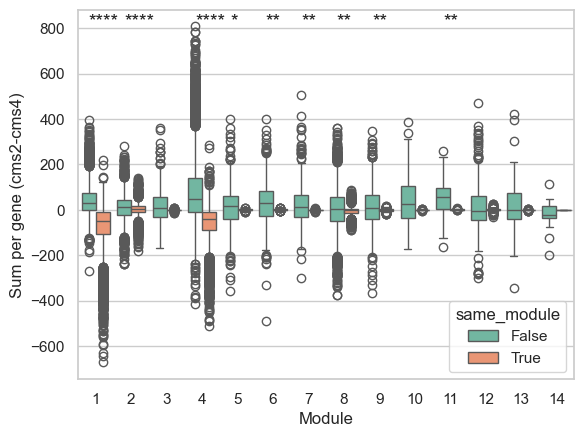

In [665]:
def return_significance(p):
    if p<1e-30:
        return '****'
    elif p<1e-3:
        return '**'
    elif p<1e-2:
        return '*'
    else:
        return('')

# seaborn set color to whitegrid
sns.set_style('whitegrid')

sigs = []
n_bonferroni = len(module_degrees['module_gene'].unique())
print(f'FWER threshold: , {0.05/n_bonferroni}')
df_wilk_genes = pd.DataFrame()
for module, tab in module_degrees[module_degrees['module_gene']<15].groupby('module_gene'):
    stat, p = stats.wilcoxon(tab[tab['same_module']==True]['diff_edge'], tab[tab['same_module']==False]['diff_edge'])
    a = return_significance(p*n_bonferroni)
    sigs.append(a)
    print(f'Module {module},stat:{stat}, p: {p}')
    df_wilk_genes = pd.concat([df_wilk_genes, pd.DataFrame({'module': module, 'stat': stat, 'p': p, 'Bonferroni FWER': np.min([1., p*n_bonferroni]),
                                                        "mean IN-module degree": np.mean(tab[tab['same_module']==True]['diff_edge']),
                                                        "mean OUT-module degree": np.mean(tab[tab['same_module']==False]['diff_edge'])}, index=[0])], axis=0)

sns.boxplot(x='module_gene', y='diff_edge', data=module_degrees[module_degrees['module_gene']<15], hue = 'same_module', palette = 'Set2')
# annotate significance
for i, txt in enumerate(sigs):
    plt.annotate(txt, (i-0.2, np.max(module_degrees[module_degrees['module_gene']<15]['diff_edge'])), fontsize=14)
plt.xlabel('Module')
plt.ylabel('Sum per gene (cms2-cms4)')
plt.show()

In [666]:
df_wilk_genes.module = df_wilk_genes.module.astype('str')

In [667]:
pd.options.display.float_format = None
pd.set_option('display.float_format', '{:.2g}'.format)
print(df_wilk_genes.to_latex(index=False,
                  formatters={"name": str.upper,"stat": "{:.2f}".format, "p": "{:.2E}".format, "Bonferroni FWER": "{:.2E}".format},
))

\begin{tabular}{lrrrrr}
\toprule
module & stat & p & Bonferroni FWER & mean IN-module degree & mean OUT-module degree \\
\midrule
1 & 385813.00 & 0.00E+00 & 0.00E+00 & -78.194178 & 43.655882 \\
2 & 2143764.00 & 1.87E-32 & 5.81E-31 & 2.421301 & 10.373974 \\
3 & 36981.00 & 5.90E-03 & 1.83E-01 & -0.132168 & 13.994770 \\
4 & 1433866.00 & 0.00E+00 & 0.00E+00 & -63.115197 & 89.458204 \\
5 & 98890.00 & 2.12E-04 & 6.58E-03 & 0.165063 & 12.623169 \\
6 & 104579.00 & 2.28E-19 & 7.05E-18 & 0.347839 & 28.194577 \\
7 & 32643.00 & 3.15E-05 & 9.78E-04 & -0.414056 & 21.782637 \\
8 & 2663962.00 & 8.13E-07 & 2.52E-05 & -4.844230 & 2.151773 \\
9 & 218707.00 & 7.61E-07 & 2.36E-05 & -1.094298 & 14.393717 \\
10 & 955.00 & 8.54E-03 & 2.65E-01 & 0.074718 & 39.860753 \\
11 & 869.00 & 1.59E-09 & 4.93E-08 & 0.659262 & 53.029421 \\
12 & 98998.00 & 3.37E-01 & 1.00E+00 & -0.456192 & 9.702970 \\
13 & 9620.00 & 6.20E-02 & 1.00E+00 & -0.154742 & 14.593134 \\
14 & 62.00 & 1.96E-01 & 1.00E+00 & 0.024142 & -20.562472 \\
\

### Now we do the same for TFs (compute degrees and differential degrees)

In [668]:
same_module_degrees = (edge_membership[edge_membership['same_module'] == True]).loc[:,['tf','module_tf','cms2','cms4','diff_edge','diff_edge_abs','is_edge']].groupby(['tf','module_tf']).sum().reset_index()
same_module_degrees['same_module'] = True
diff_module_degrees = (edge_membership[edge_membership['same_module'] == False]).loc[:,['tf','module_tf','cms2','cms4','diff_edge','diff_edge_abs','is_edge']].groupby(['tf','module_tf']).sum().reset_index()
diff_module_degrees['same_module'] = False
tf_degrees = pd.concat([same_module_degrees, diff_module_degrees], axis=0)
tf_degrees.sort_values('tf')

tf_degrees['differential_degree'] = tf_degrees['cms2'] - tf_degrees['cms4']


In [669]:
tf_degrees.head()

tf  module_tf     cms2     cms4  diff_edge  diff_edge_abs  is_edge  \
0   ALX1          1  5.6e+03  7.5e+03   -1.8e+03          2e+03     3601   
1   ALX3          2  3.9e+03  3.9e+03        -45        5.4e+02     3351   
2   ALX4          1  4.7e+03  6.4e+03   -1.6e+03        1.8e+03     3601   
3     AR          2 -1.5e+03 -1.6e+03         82        3.3e+02     3351   
4  ARGFX          2  6.1e+03  6.2e+03        -89        8.7e+02     3351   

   same_module  differential_degree  
0         True             -1.8e+03  
1         True                  -45  
2         True             -1.6e+03  
3         True                   82  
4         True                  -89

FWER threshold: , 0.0035714285714285718
Module 1,stat:40.0, p: 1.0248886991655897e-42
Module 2,stat:7088.0, p: 1.7654741798452378e-12
Module 3,stat:11.0, p: 0.0008392333984375
Module 4,stat:788.0, p: 9.046025939011586e-42
Module 5,stat:207.0, p: 0.83135736733675
Module 6,stat:2.0, p: 1.3969838619232178e-09
Module 7,stat:83.0, p: 0.4304332733154297
Module 8,stat:254.0, p: 1.909507566350996e-06
Module 9,stat:136.0, p: 0.00011535796875250526
Module 10,stat:3.0, p: 1.0
Module 11,stat:0.0, p: 0.03125
Module 12,stat:28.0, p: 0.0006937980651855469
Module 13,stat:0.0, p: 0.015625
Module 14,stat:0.0, p: 1.0


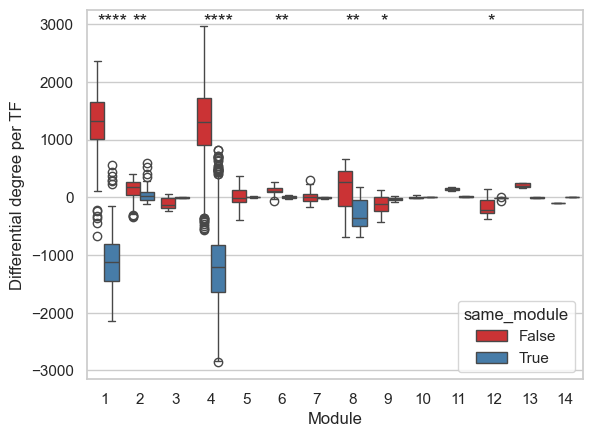

In [670]:
sigs = []
n_bonferroni = len(tf_degrees['module_tf'].unique())
print(f'FWER threshold: , {0.05/n_bonferroni}')
df_wilk_tfs = pd.DataFrame()

for module, tab in tf_degrees[tf_degrees['module_tf']<15].groupby('module_tf'):
    

    stat, p = stats.wilcoxon(tab[tab['same_module']==True]['differential_degree'], tab[tab['same_module']==False]['differential_degree'])
    a = return_significance(p*n_bonferroni)
    sigs.append(a)
    print(f'Module {module},stat:{stat}, p: {p}')
    
    df_wilk_tfs = pd.concat([df_wilk_tfs, pd.DataFrame({'module': module, 
                                                        'stat': stat, 
                                                        'p': p, 
                                                        'Bonferroni FWER': np.min([1., p*n_bonferroni]),
                                                        "mean IN-module degree": np.mean(tab[tab['same_module']==True]['differential_degree']),
                                                        "mean OUT-module degree": np.mean(tab[tab['same_module']==False]['differential_degree'])                                                       
                                                        }, index=[0])], axis=0)


sns.boxplot(x='module_tf', y='differential_degree', data=tf_degrees[tf_degrees['module_tf']<15], hue = 'same_module', palette = 'Set1')
# annotate significance
for i, txt in enumerate(sigs):
    plt.annotate(txt, (i-0.2, np.max(tf_degrees[tf_degrees['module_tf']<15]['differential_degree'])), fontsize=14)
plt.xlabel('Module')
plt.ylabel('Differential degree per TF')
plt.show()

In [671]:
pd.options.display.float_format = None
pd.set_option('display.float_format', '{:.2g}'.format)
print(df_wilk_tfs.to_latex(index=False,
                  formatters={"name": str.upper,"stat": "{:.2f}".format, "p": "{:.2E}".format, "Bonferroni FWER": "{:.2E}".format},
))

\begin{tabular}{rrrrrr}
\toprule
module & stat & p & Bonferroni FWER & mean IN-module degree & mean OUT-module degree \\
\midrule
1 & 40.00 & 1.02E-42 & 1.43E-41 & -1121.821654 & 1331.685448 \\
2 & 7088.00 & 1.77E-12 & 2.47E-11 & 33.390045 & 133.276001 \\
3 & 11.00 & 8.39E-04 & 1.17E-02 & -3.249790 & -110.794156 \\
4 & 788.00 & 9.05E-42 & 1.27E-40 & -1139.382961 & 1268.302363 \\
5 & 207.00 & 8.31E-01 & 1.00E+00 & 3.910279 & -2.354879 \\
6 & 2.00 & 1.40E-09 & 1.96E-08 & 8.815545 & 115.128064 \\
7 & 83.00 & 4.30E-01 & 1.00E+00 & -8.550258 & 13.984968 \\
8 & 254.00 & 1.91E-06 & 2.67E-05 & -282.032701 & 170.765688 \\
9 & 136.00 & 1.15E-04 & 1.62E-03 & -28.205519 & -121.859152 \\
10 & 3.00 & 1.00E+00 & 1.00E+00 & 1.892866 & -2.441624 \\
11 & 0.00 & 3.12E-02 & 4.38E-01 & 11.427210 & 139.448435 \\
12 & 28.00 & 6.94E-04 & 9.71E-03 & -13.333253 & -158.706423 \\
13 & 0.00 & 1.56E-02 & 2.19E-01 & -4.686480 & 206.724260 \\
14 & 0.00 & 1.00E+00 & 1.00E+00 & 0.458702 & -102.928285 \\
\bottomrule
\en

### Check the leading TF by modularity

In [672]:
membership_tf = membership[membership['node_type']=='A']
map_n_tf = membership_tf.loc[:,['module','node_name']].groupby('module').count().rename(columns={'node_name':'n_tf'})
membership_tf = membership_tf.merge(map_n_tf, left_on='module', right_index=True)
membership_tf['raw_modularity'] = membership_tf['modularity'] * membership_tf['n_tf']
membership_tf

node  module  modularity node_name node_type gene_symbol  n_tf  \
0       ALX1_A       1      0.0061      ALX1         A        ALX1   251   
1       ALX3_A       2       0.011      ALX3         A        ALX3   243   
2       ALX4_A       1      0.0052      ALX4         A        ALX4   251   
3         AR_A       2      0.0014        AR         A          AR   243   
4      ARGFX_A       2       0.012     ARGFX         A       ARGFX   243   
..         ...     ...         ...       ...       ...         ...   ...   
992   ZSCAN4_A       2      0.0026    ZSCAN4         A      ZSCAN4   243   
993   ZSCAN5_A       4      0.0023    ZSCAN5         A      ZSCAN5   267   
994  ZSCAN5C_A       4     0.00099   ZSCAN5C         A     ZSCAN5C   267   
995   ZSCAN9_A       1      0.0028    ZSCAN9         A      ZSCAN9   251   
996     ZZZ3_A       1      0.0014      ZZZ3         A        ZZZ3   251   

     raw_modularity  
0               1.5  
1               2.7  
2               1.3  
3              0.35  
4                 3  
..              ...  
992            0.64  
993            0.61  
994            0.27  
995             0.7  
996            0.36  

[997 rows x 8 columns]

In [673]:
membership_gene = membership[membership['node_type']=='B']

In [674]:
# Cluster of interest 1,2 4,6,8
membership_tf[membership_tf['module'].isin([1,2,4,6,8])].sort_values(['raw_modularity'], ascending=[False])

node  module  modularity node_name node_type gene_symbol  n_tf  \
742  ZNF180_A       4       0.014    ZNF180         A      ZNF180   267   
867  ZNF529_A       4       0.014    ZNF529         A      ZNF529   267   
336    LHX9_A       2       0.015      LHX9         A        LHX9   243   
335    LHX8_A       2       0.015      LHX8         A        LHX8   243   
325    LBX1_A       2       0.015      LBX1         A        LBX1   243   
..        ...     ...         ...       ...       ...         ...   ...   
675   ZBTB3_A       8      0.0011     ZBTB3         A       ZBTB3    59   
89     E2F2_A       6      0.0018      E2F2         A        E2F2    32   
842  ZNF449_A       8     0.00094    ZNF449         A      ZNF449    59   
398    NFE2_A       8     0.00059      NFE2         A        NFE2    59   
205   GMEB1_A       2     1.6e-05     GMEB1         A       GMEB1   243   

     raw_modularity  
742             3.7  
867             3.7  
336             3.6  
335             3.5  
325             3.5  
..              ...  
675           0.062  
89            0.056  
842           0.055  
398           0.035  
205          0.0039  

[852 rows x 8 columns]

In [321]:
top_tfs = pd.DataFrame()
for k, tab in membership_tf.groupby('module'):
    print(k)
    # select the first 100 edges based on the first 10 tf modularities and the first 10 gene modularities
    print(tab.sort_values('modularity', ascending=False)['node_name'].values[:10].tolist())
    top_tfs = pd.concat([top_tfs, tab.sort_values('modularity', ascending=False).head(10)], axis=0)

1
['ZNF334', 'FOXD2', 'HMG20B', 'ZNF33B', 'FOXD3', 'POU3F3', 'VSX2', 'ARID5B', 'NR1H4', 'ZNF25']
2
['LHX9', 'LHX8', 'LBX1', 'PBX4', 'DLX6', 'LHX2', 'SHOX2', 'PRRX1', 'PRRX2', 'SHOX']
3
['ARNT', 'ARNT2', 'BHLHE41', 'ARNTL', 'TFE3', 'BHLHE40', 'MLXIPL', 'MLX', 'SREBF2', 'USF1']
4
['ZNF180', 'ZNF529', 'ZNF341', 'ZNF444', 'ZNF467', 'PRDM9', 'ZNF468', 'ZNF304', 'ZNF383', 'ZNF880']
5
['FOSB', 'FOSL2', 'CREB5', 'ATF3', 'CREM', 'ATF2', 'CREB3L4', 'CREB1', 'FOSL1', 'ATF7']
6
['OLIG3', 'OLIG1', 'ATOH7', 'BHLHE23', 'NEUROD2', 'NEUROG1', 'NEUROG2', 'BHLHE22', 'PPARD', 'RXRA']
7
['HEY1', 'HEY2', 'HEYL', 'HES2', 'HES5', 'HES1', 'HES7', 'MYCN', 'HOXD1', 'HOXC8']
8
['ZNF225', 'ZNF487', 'ZNF235', 'ZNF287', 'ZNF443', 'PRDM6', 'ZNF182', 'ZNF496', 'ZNF181', 'ZNF98']
9
['ELK4', 'ELK3', 'ETV4', 'ETV1', 'ETV3', 'ERF', 'GABPA', 'FLI1', 'FEV', 'ELK1']
10
['GLI3', 'GLI1', 'GLI2']
11
['HOXC9', 'HOXB9', 'HOXA11', 'HOXA10', 'HOXD11', 'KDM2B']
12
['KLF6', 'KLF12', 'KLF14', 'KLF2', 'SP3', 'KLF4', 'KLF3', 'SP9', 'KLF

/Users/violafanfani/miniconda3/envs/m1-ml-py10/lib/python3.12/site-packages/seaborn/categorical.py:2761: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


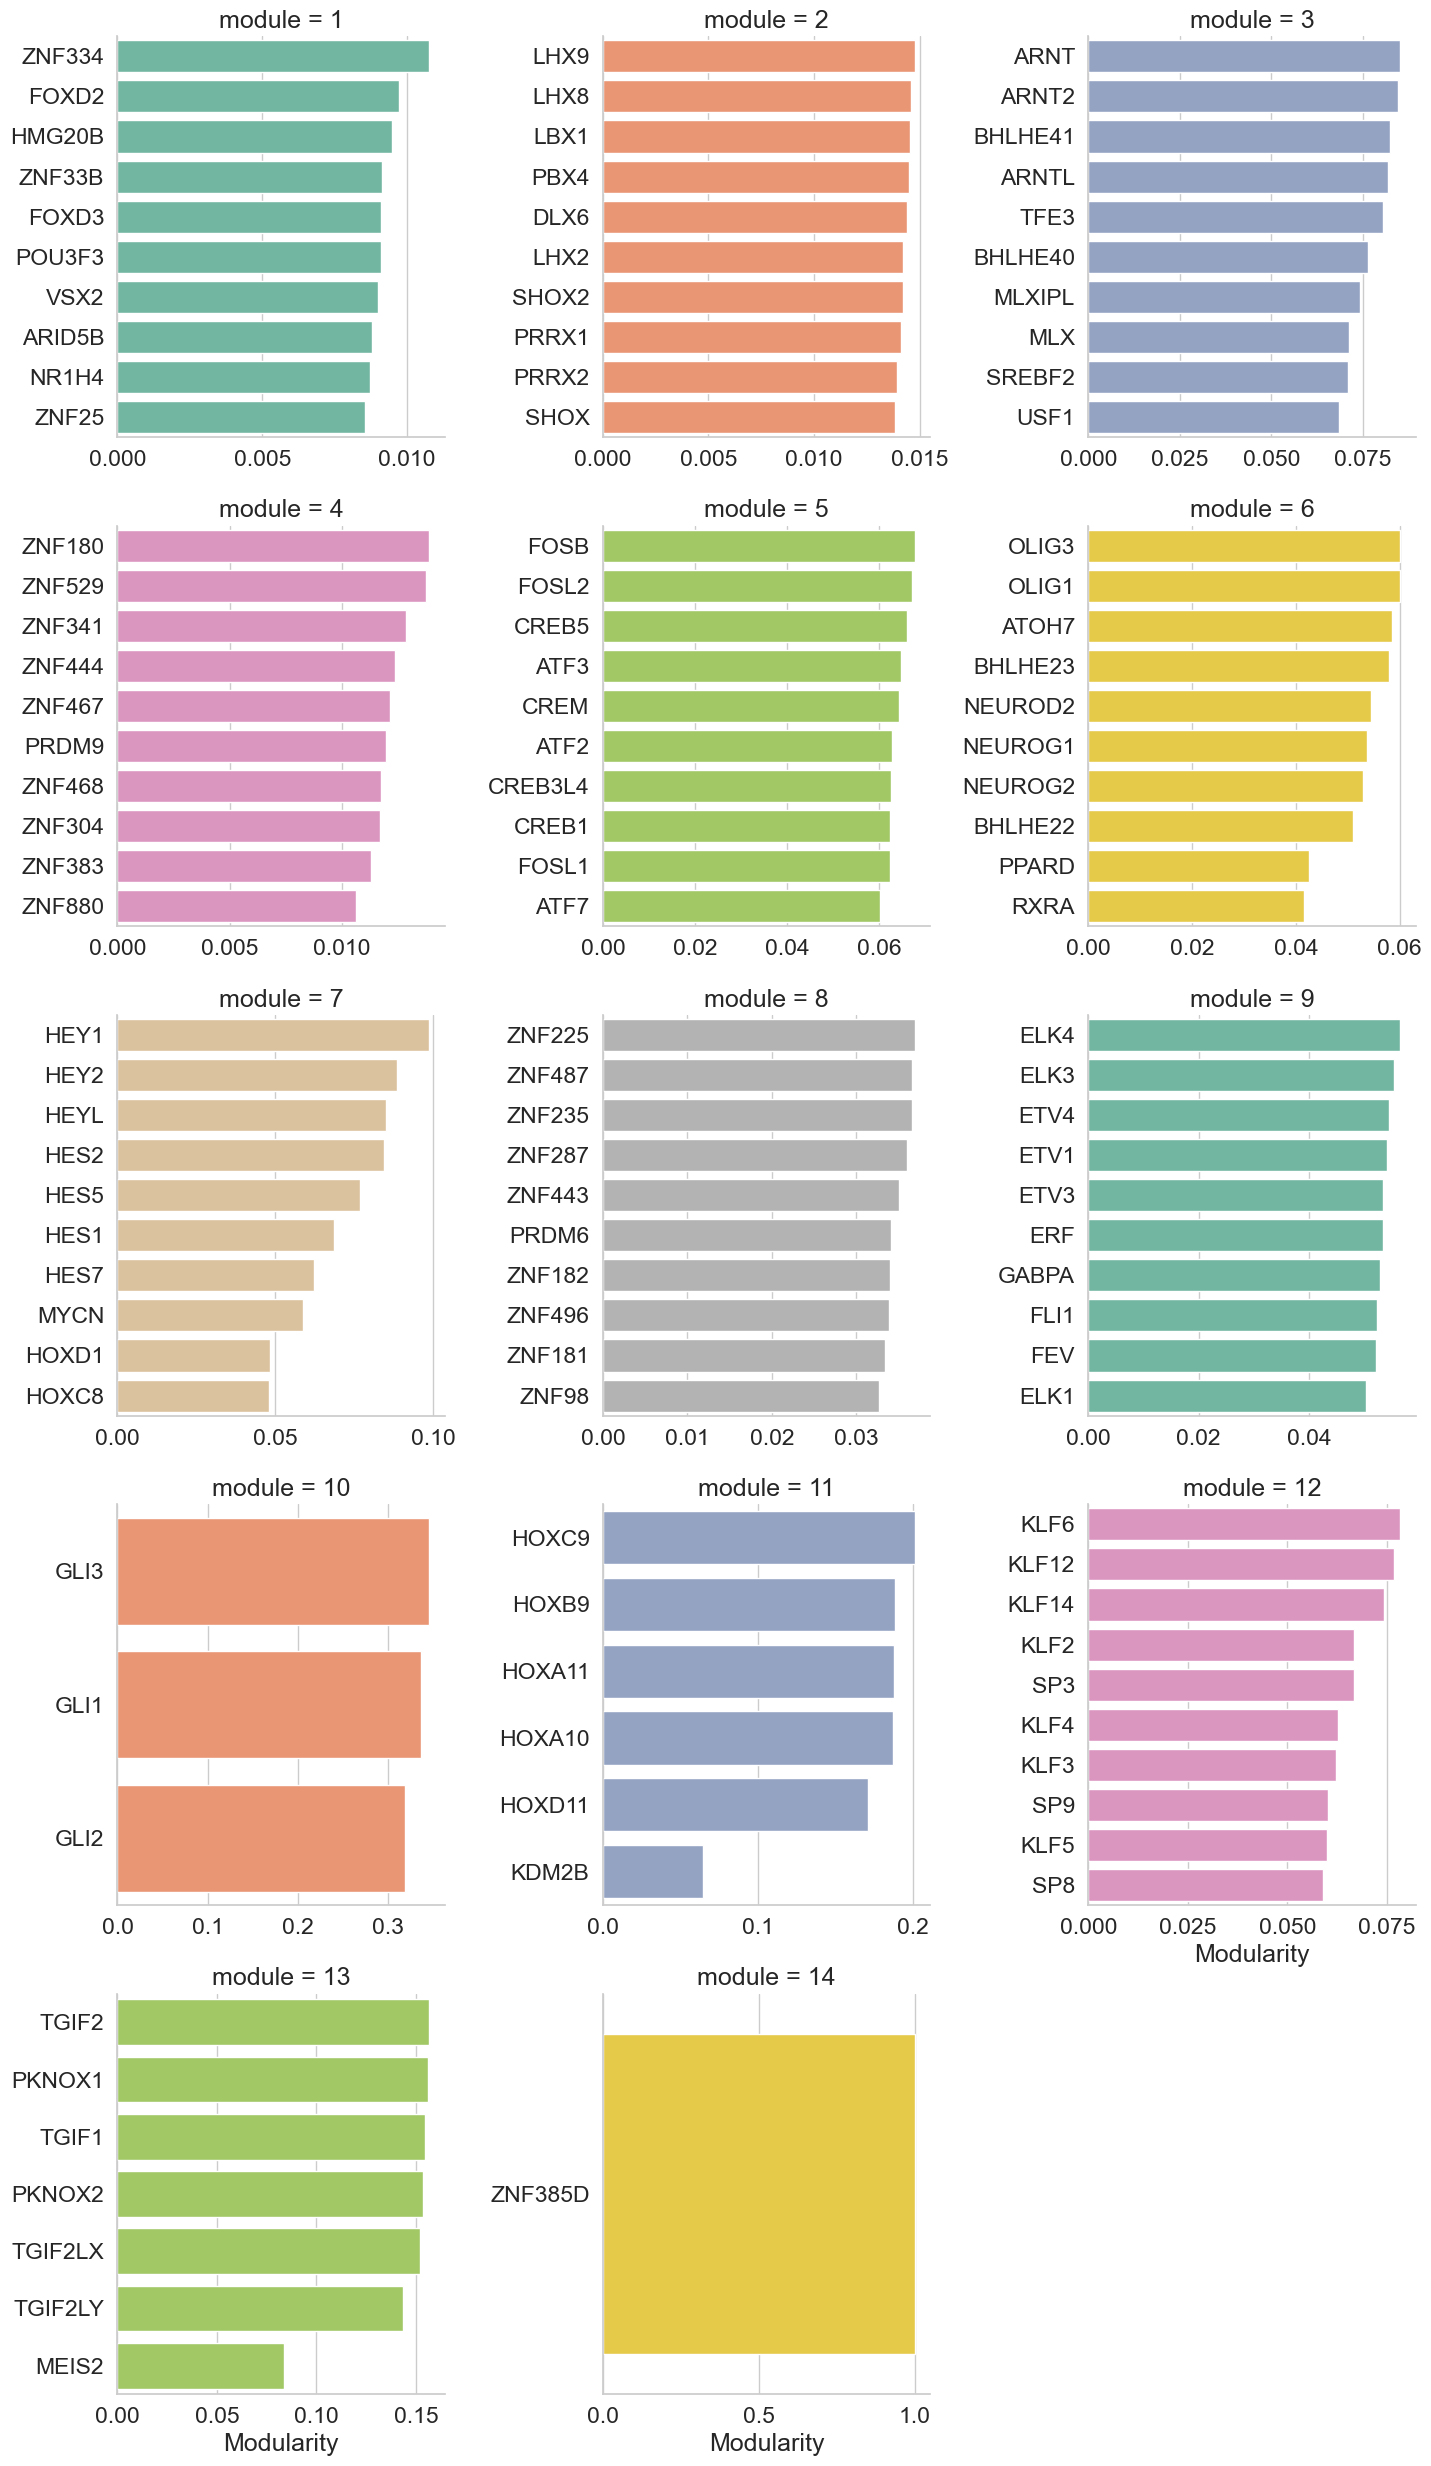

In [675]:
sns.set_context("notebook", font_scale=1.5)
g1 = sns.catplot(col='module', x='modularity', data=top_tfs, y='node_name', palette = 'Set2', hue = 'module', ax = ax, col_wrap=3, height=5, sharey=False, kind = 'bar', legend = False, sharex=False)
g1.set_xlabels('Modularity')
g1.set_ylabels('')
g1.fig.savefig(outputDir + 'top_tfs_modules_all.pdf', dpi=300)

/Users/violafanfani/miniconda3/envs/m1-ml-py10/lib/python3.12/site-packages/seaborn/categorical.py:2761: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


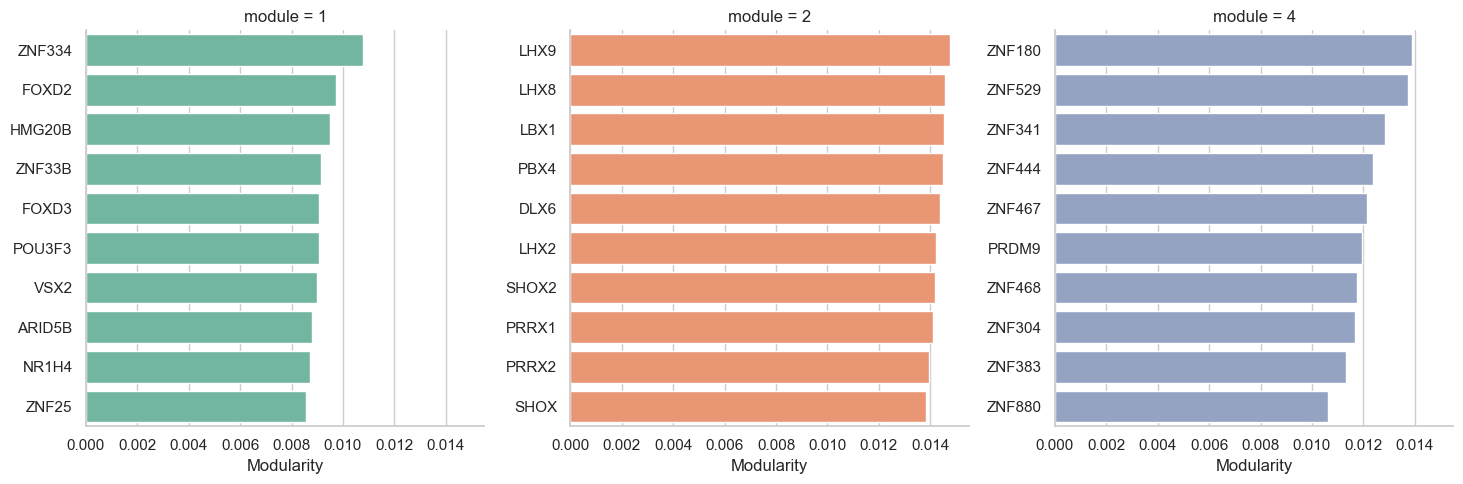

In [676]:
sns.set_context("notebook")
g1 = sns.catplot(col='module', x='modularity', data=top_tfs[top_tfs['module'].isin([1,2,4])], y='node_name', palette = 'Set2', hue = 'module', ax = ax, col_wrap=3, height=5, sharey=False, kind = 'bar', legend = False)
g1.set_xlabels('Modularity')
g1.set_ylabels('')
g1.fig.savefig(outputDir + 'top_tfs_modules_1_2_4.pdf', dpi=300)

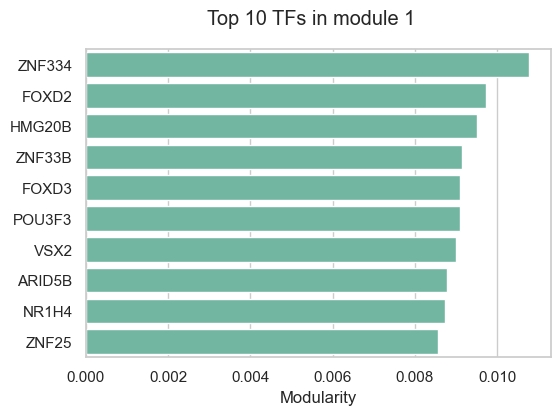

In [677]:
sns.set_context("notebook")
f, ax = plt.subplots(figsize=(6,4))
sns.barplot(x='modularity', data=top_tfs[top_tfs['module'].isin([1])], y='node_name', palette = 'Set2', hue = 'module',legend = False,ax = ax)
ax.set_xlabel('Modularity')
ax.set_ylabel('')
f.suptitle('Top 10 TFs in module 1')
f.savefig(outputDir + 'top_tfs_modules_1.pdf', dpi=300)

## We plot some of the results from the KEGG pathway analysis in R

In [682]:
kegg_alpaca = pd.read_csv("../results/alpaca-batch-coad-subtype-connnectivity-20250317/cms2_cms4_pathway_kegg.tsv", sep ='\t')
kegg_alpaca.head()

category                    subcategory  \
0                        Human Diseases                 Immune disease   
1  Environmental Information Processing            Signal transduction   
2                        Human Diseases  Infectious disease: parasitic   
3                        Human Diseases         Cardiovascular disease   
4                        Human Diseases  Infectious disease: bacterial   

         ID                Description GeneRatio   BgRatio  pvalue  p.adjust  \
0  hsa05323       Rheumatoid arthritis   42/1104   95/9436 1.3e-15   4.3e-13   
1  hsa04668      TNF signaling pathway   39/1104  119/9436 8.1e-10   1.4e-07   
2  hsa05140              Leishmaniasis   28/1104   79/9436 2.9e-08   3.3e-06   
3  hsa05417  Lipid and atherosclerosis   53/1104  216/9436 8.2e-08     7e-06   
4  hsa05152               Tuberculosis   46/1104  182/9436 2.4e-07   1.6e-05   

   qvalue                                             geneID  Count  module  
0 3.3e-13  3683/51606/10673/6347/942/523/3552/6372/3553/1...     42       1  
1 1.1e-07  843/8837/6401/330/355/6416/1906/1540/5594/9252...     39       1  
2 2.5e-06  3459/3717/5594/3552/3676/3553/7099/7097/2212/5...     28       1  
3 5.3e-06  6401/355/6416/387/4775/3717/5594/7494/57534/35...     53       1  
4 1.2e-05  843/3920/3459/51606/387/7879/30835/3717/5594/8...     46       1

In [ ]:
# Function to plot the KEGG pathways for a given module
def plot_pathways_kegg_module(data, module, th = 0.01, output_file=None):
    data = data[data['p.adjust'] < th]
    kas_1 = data[data['module']==module].sort_values(['category','Count'], ascending=[True, False])
    kas_1['-log10(p.adjust)'] = -np.log10(kas_1['p.adjust'])
    # 
    f, ax = plt.subplots(figsize=(4, len(kas_1)*0.22))
    sns.scatterplot(y = 'Description', hue = 'subcategory', x = 'Count' , 
                    data=kas_1, palette = sns.color_palette("tab20", 20), ax = ax, size = '-log10(p.adjust)', sizes=(20, 300))
    # draw row lines for each category with name on the side, you need to check how long each category is 
    maxx = kas_1['Count'].max()
    for i in range(0,len(kas_1)):
        if i == 0:
            ax.text(maxx+2, i-0.5, kas_1.iloc[i]['category'], fontsize=9, va='center', ha='right')
        else: 
            if kas_1.iloc[i]['category'] != kas_1.iloc[i-1]['category']:
                if kas_1.iloc[i]['category']=='Environmental Information Processing':
                    short = 'Env. Info. Processing'
                else:
                    short = kas_1.iloc[i]['category']
                ax.text(maxx+2, i + len(kas_1[kas_1['category'] == kas_1.iloc[i]['category']])/2-0.5, short, fontsize=9, va='center', ha='right')
                ax.axhline(i-0.5, color='black', linestyle='--')
    
    f.suptitle(f'KEGG pathways in module {module}', fontsize=14)
    # Legend outside
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.show()
    
    if output_file:
        f.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f'Saved figure to {output_file}')



Plotting KEGG pathways for module 1


/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:7: UserWarning: The palette list has more values (20) than needed (16), which may not be intended.
  sns.scatterplot(y = 'Description', hue = 'subcategory', x = 'Count' ,
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


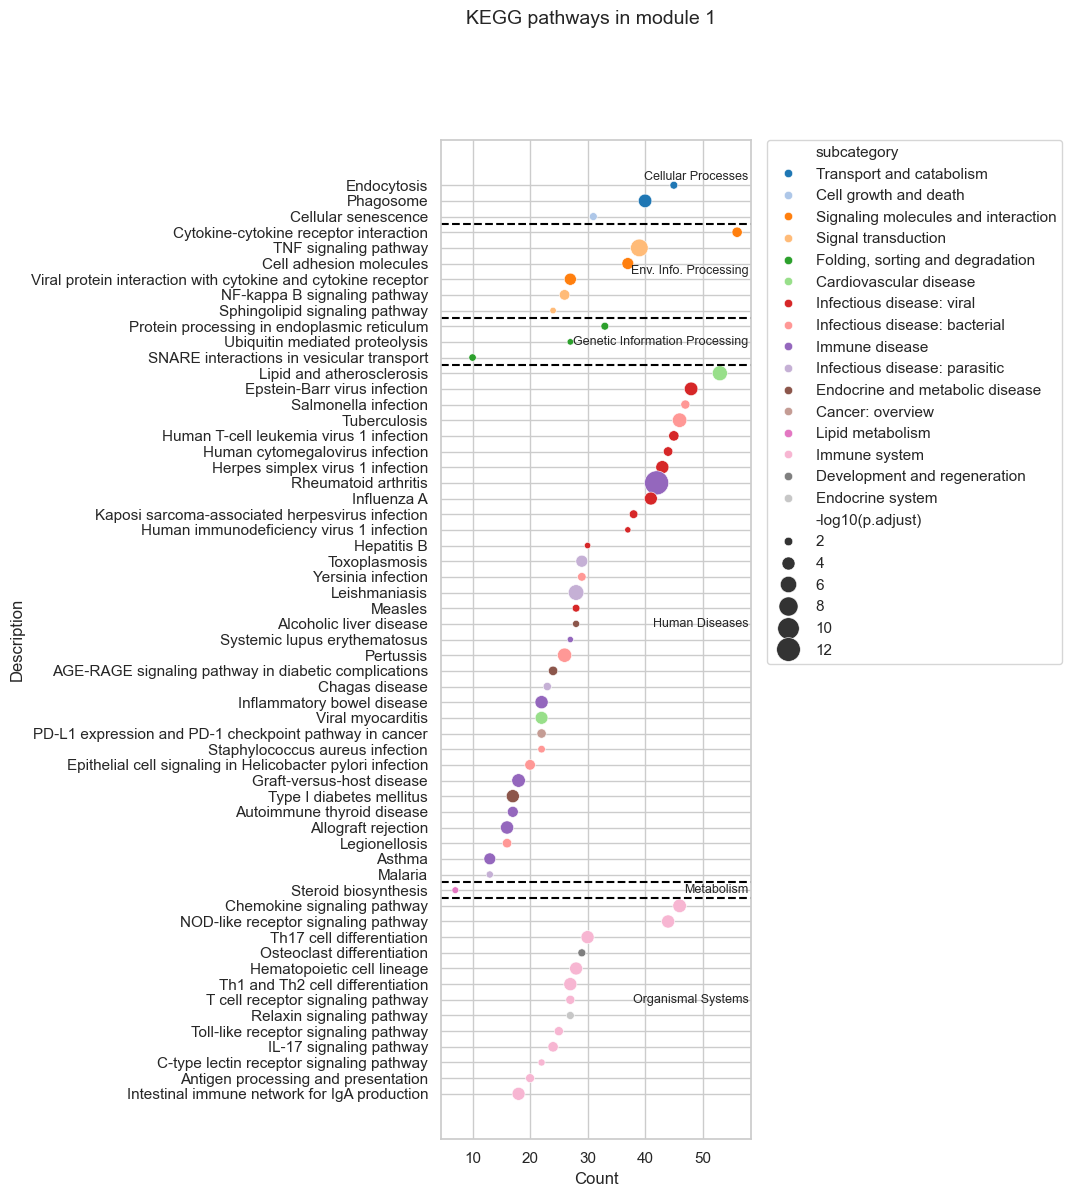

Saved figure to ../results/alpaca-batch-coad-subtype-connnectivity-20250317/kegg_module_1.pdf
Plotting KEGG pathways for module 2


/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:7: UserWarning: 
The palette list has fewer values (20) than needed (26) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(y = 'Description', hue = 'subcategory', x = 'Count' ,
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


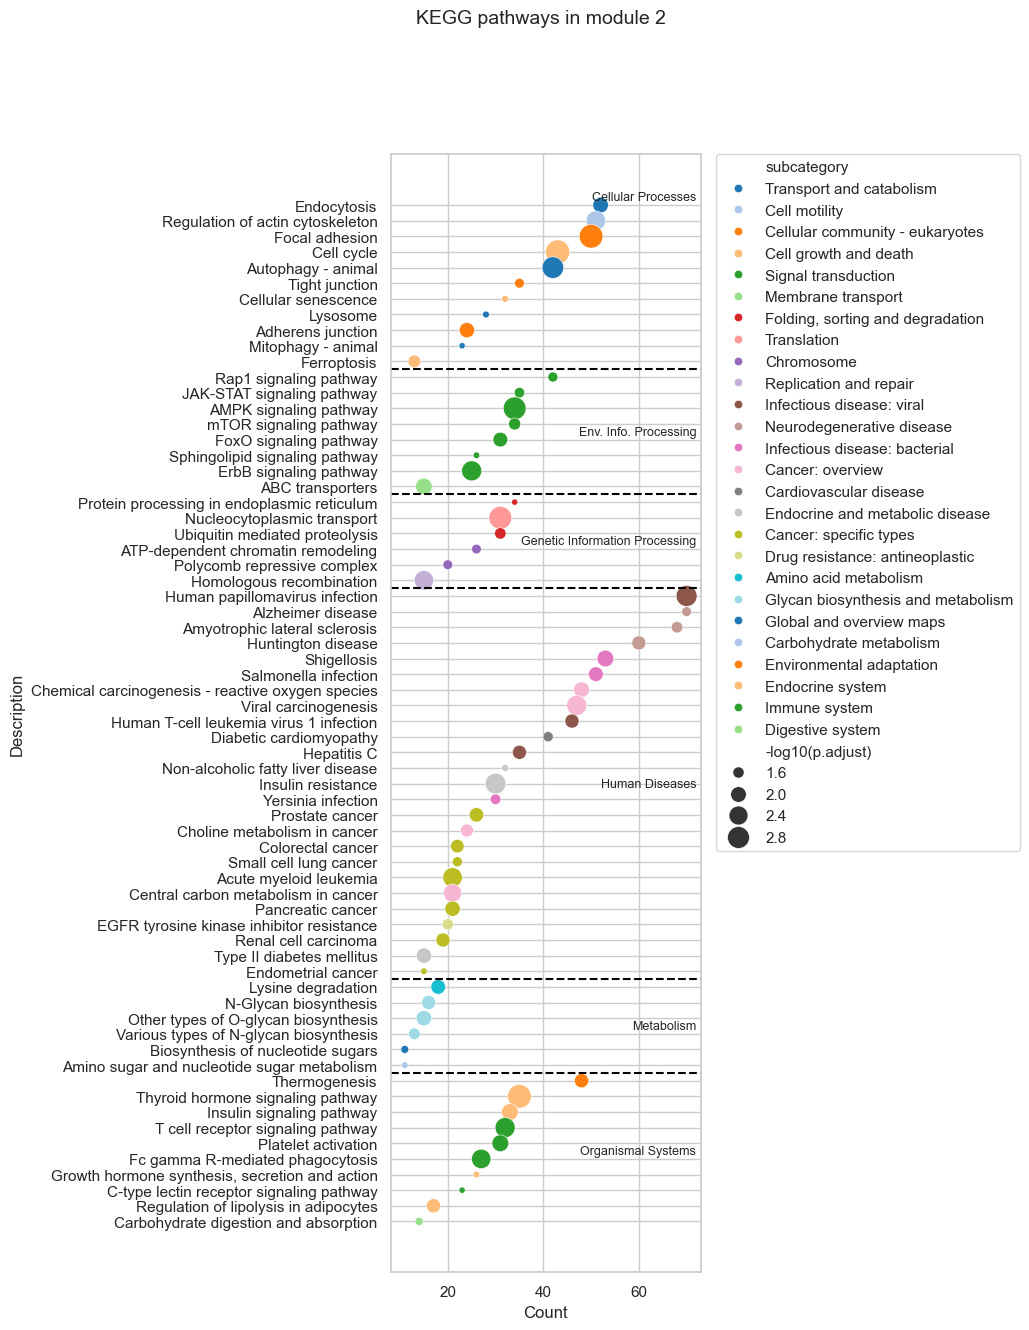

Saved figure to ../results/alpaca-batch-coad-subtype-connnectivity-20250317/kegg_module_2.pdf
Plotting KEGG pathways for module 3


/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:7: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.scatterplot(y = 'Description', hue = 'subcategory', x = 'Count' ,
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


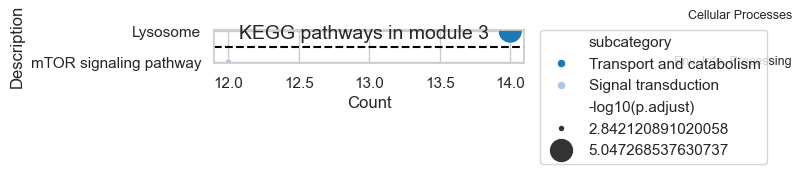

Saved figure to ../results/alpaca-batch-coad-subtype-connnectivity-20250317/kegg_module_3.pdf
Plotting KEGG pathways for module 4


/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:7: UserWarning: 
The palette list has fewer values (20) than needed (25) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(y = 'Description', hue = 'subcategory', x = 'Count' ,
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


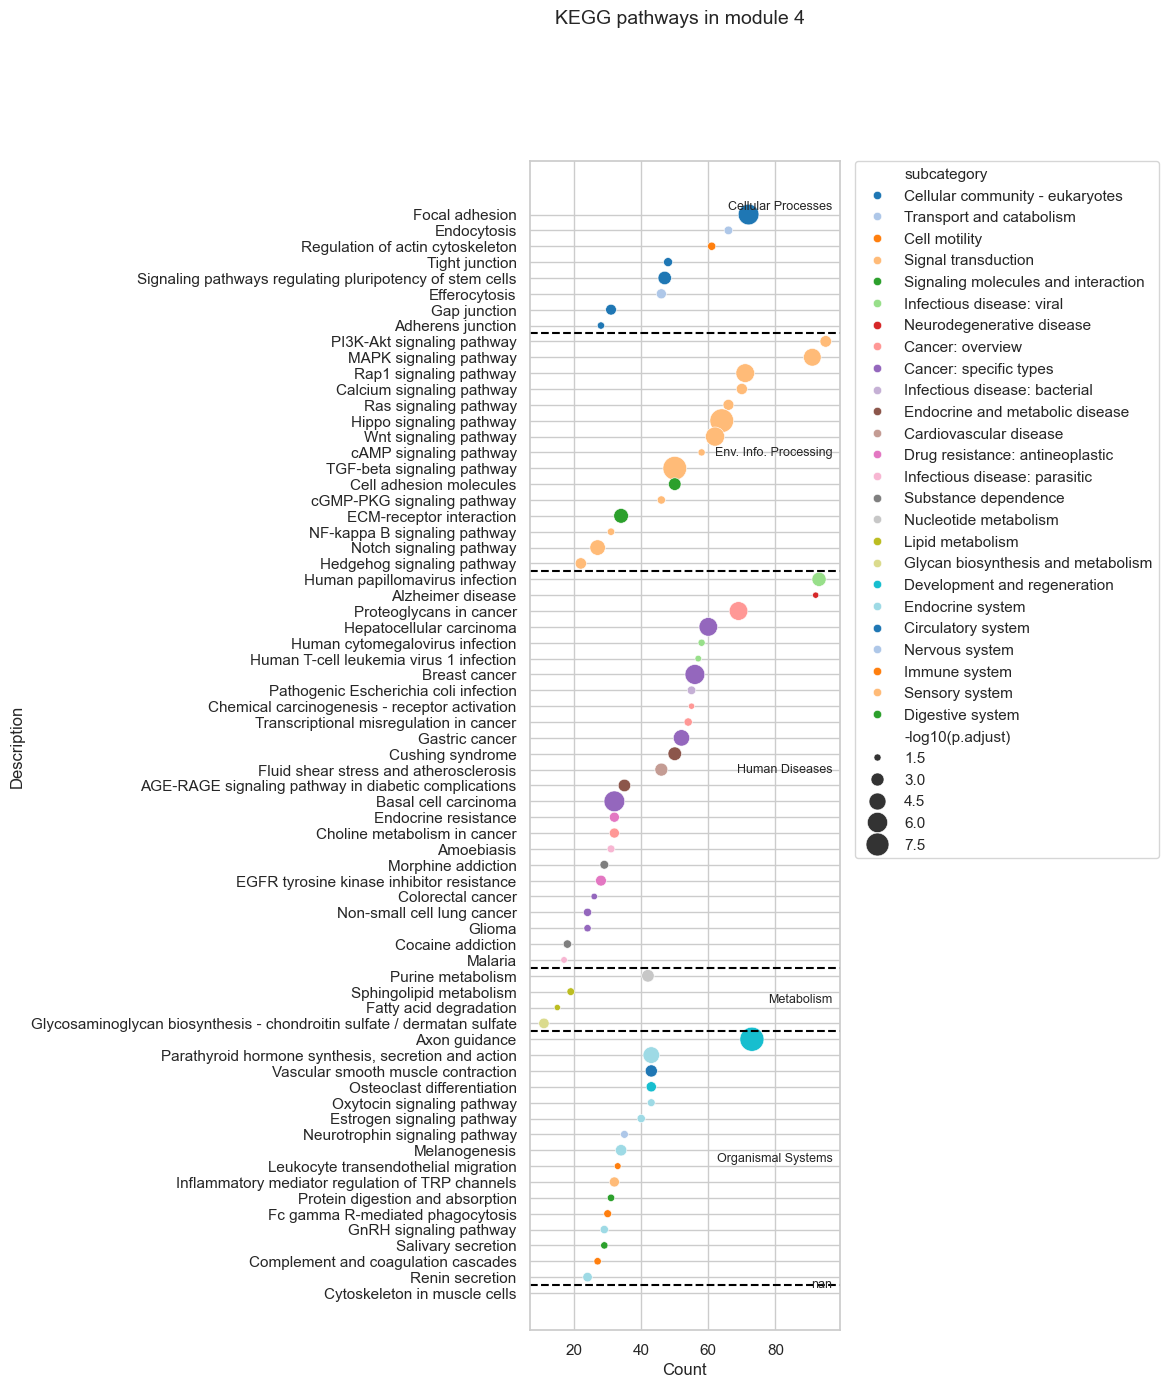

Saved figure to ../results/alpaca-batch-coad-subtype-connnectivity-20250317/kegg_module_4.pdf
Plotting KEGG pathways for module 7


/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:7: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.scatterplot(y = 'Description', hue = 'subcategory', x = 'Count' ,
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


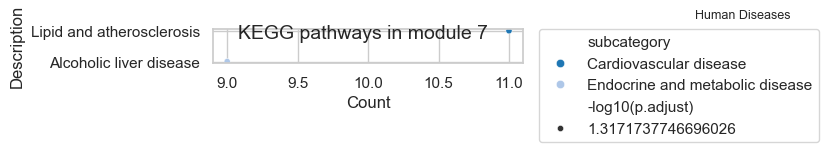

Saved figure to ../results/alpaca-batch-coad-subtype-connnectivity-20250317/kegg_module_7.pdf
Plotting KEGG pathways for module 8


/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:7: UserWarning: The palette list has more values (20) than needed (15), which may not be intended.
  sns.scatterplot(y = 'Description', hue = 'subcategory', x = 'Count' ,
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


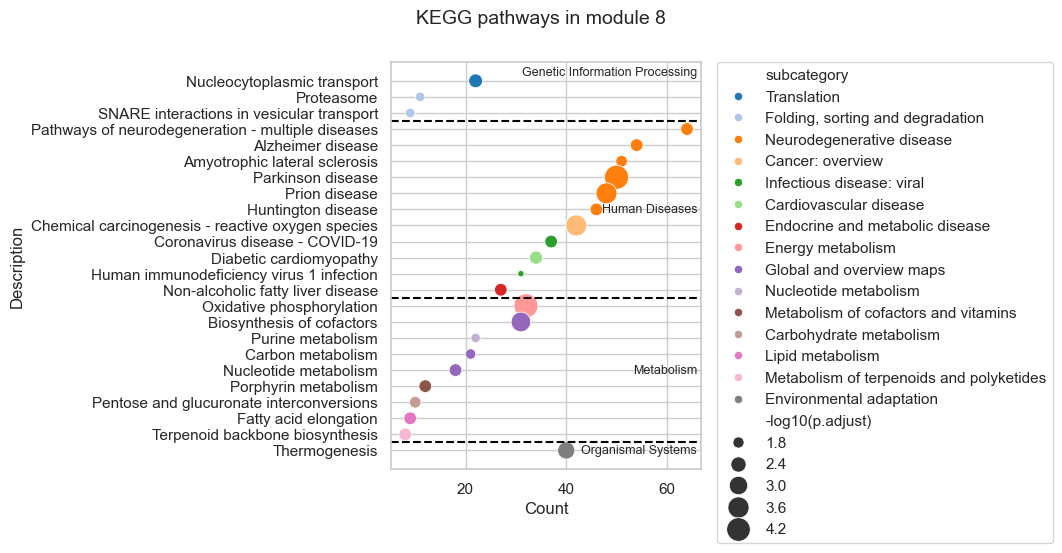

Saved figure to ../results/alpaca-batch-coad-subtype-connnectivity-20250317/kegg_module_8.pdf
Plotting KEGG pathways for module 9


/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:7: UserWarning: The palette list has more values (20) than needed (6), which may not be intended.
  sns.scatterplot(y = 'Description', hue = 'subcategory', x = 'Count' ,
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


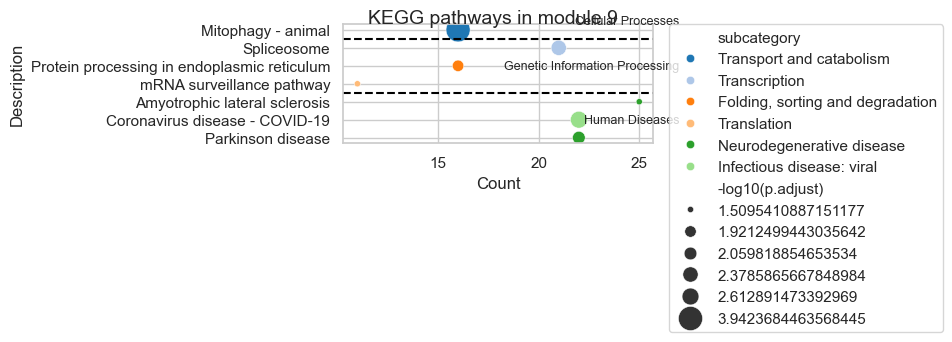

Saved figure to ../results/alpaca-batch-coad-subtype-connnectivity-20250317/kegg_module_9.pdf
Plotting KEGG pathways for module 11


/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:7: UserWarning: The palette list has more values (20) than needed (1), which may not be intended.
  sns.scatterplot(y = 'Description', hue = 'subcategory', x = 'Count' ,
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


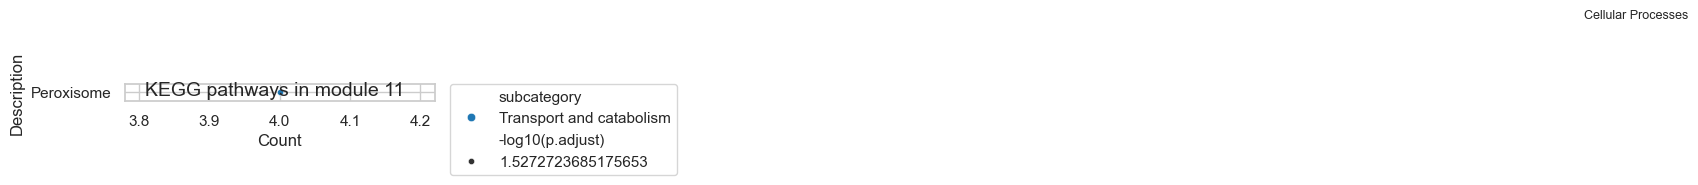

Saved figure to ../results/alpaca-batch-coad-subtype-connnectivity-20250317/kegg_module_11.pdf


In [684]:
kegg_alpaca_significant = kegg_alpaca[kegg_alpaca['p.adjust'] < 0.05]
for m in range(14):
    if len(kegg_alpaca_significant[kegg_alpaca_significant['module']==m]) > 0:
        print(f'Plotting KEGG pathways for module {m}')
        plot_pathways_kegg_module(kegg_alpaca, m, th=0.05, output_file=outputDir + f'kegg_module_{m}.pdf')

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:7: UserWarning: The palette list has more values (20) than needed (19), which may not be intended.
  sns.scatterplot(y = 'Description', hue = 'subcategory', x = 'Count' ,
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/721400589.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


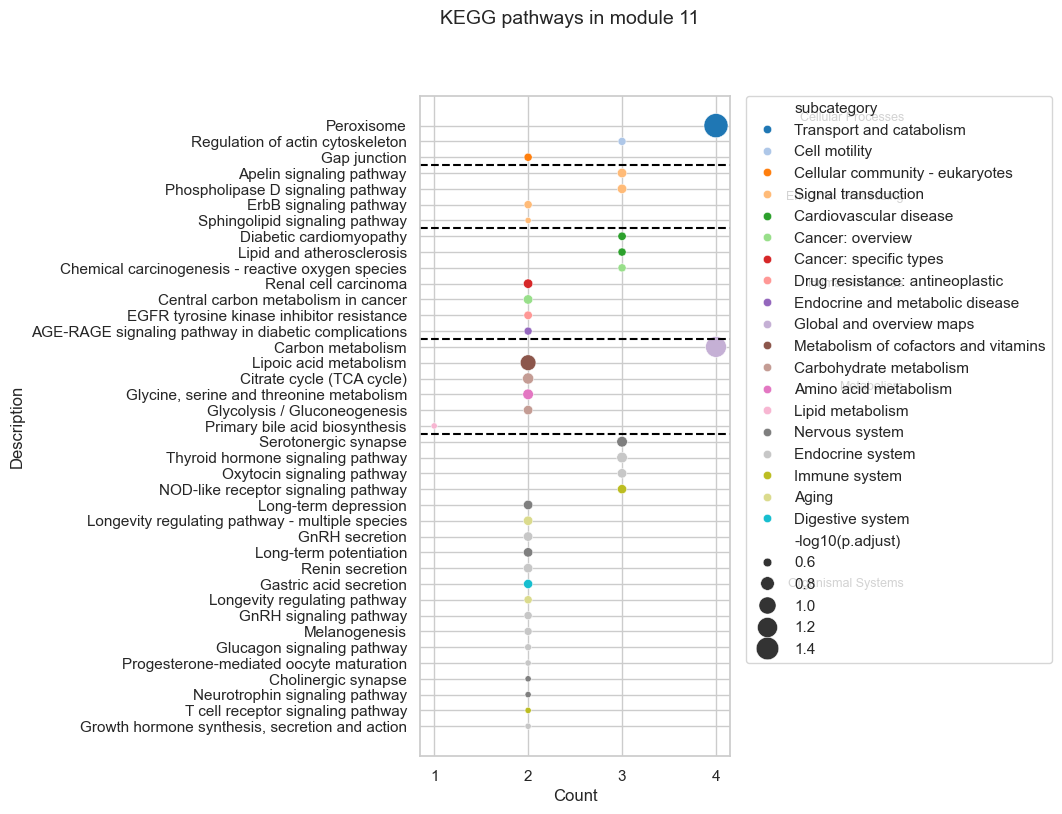

Saved figure to ../results/alpaca-batch-coad-subtype-connnectivity-20250317/kegg_module_11.pdf


In [685]:
# We check the pathways in module 11 with a less stringent threshold
plot_pathways_kegg_module(kegg_alpaca,11, th=0.3, output_file=outputDir + f'kegg_module_11.pdf')

### Complete plot with all results

In [687]:
kegg_alpaca_significant = kegg_alpaca[kegg_alpaca['p.adjust'] < 0.05]

kegg_alpaca_significant['-log10(p.adjust)'] = -np.log10(kegg_alpaca_significant['p.adjust'])
kegg_alpaca_significant = kegg_alpaca_significant.sort_values(by = ['category','subcategory','module']).dropna(subset=['subcategory'])

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/2674076228.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kegg_alpaca_significant['-log10(p.adjust)'] = -np.log10(kegg_alpaca_significant['p.adjust'])


In [688]:
kegg_alpaca_significant = kegg_alpaca_significant.sort_values(by = 'category').dropna(subset=['subcategory'])
map_index = {i:k for k,i in enumerate(kegg_alpaca_significant['Description'].unique())}
kegg_alpaca_significant['i'] = kegg_alpaca_significant.Description.map(map_index)
kegg_alpaca_significant

# Can you generate a palette with a different color for each category and then subcolors of the palette for each
# subcategory?
colors = ['Reds', 'Blues', 'Greens', 'Purples', 'Oranges', 'Greys','winter','autumn']
whole_palette = {}
specific_palette = {}
i = 0
for k in kegg_alpaca_significant['category'].unique():
    print(k,i)
    whole_palette[k] = colors[i]
    if str(k) == 'nan':
        subcategories = kegg_alpaca_significant[kegg_alpaca_significant['category']==k]['subcategory'].unique()
        for j, sub in enumerate(subcategories):
            specific_palette[sub] = 'k'
    else:
        subcategories = kegg_alpaca_significant[kegg_alpaca_significant['category']==k]['subcategory'].unique()
        pal = sns.color_palette(colors[i], len(subcategories))
        for j, sub in enumerate(subcategories):
            specific_palette[sub] = pal[j]
        i = i + 1
    

# map the subcategories to the colors in specific_palette
kegg_alpaca_significant['subcategory_color'] = [specific_palette[sub] if sub in specific_palette else 'k' for sub in kegg_alpaca_significant['subcategory']]


map_nonnul_modules = {k:i for i, k in enumerate(sorted(kegg_alpaca_significant['module'].unique())) if k != 0}
kegg_alpaca_significant['module_map'] = kegg_alpaca_significant['module'].map(map_nonnul_modules)
map_nonnul_modules

Cellular Processes 0
Environmental Information Processing 1
Genetic Information Processing 2
Human Diseases 3
Metabolism 4
Organismal Systems 5


{np.int64(1): 0,
 np.int64(2): 1,
 np.int64(3): 2,
 np.int64(4): 3,
 np.int64(7): 4,
 np.int64(8): 5,
 np.int64(9): 6,
 np.int64(11): 7}

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/581196669.py:44: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


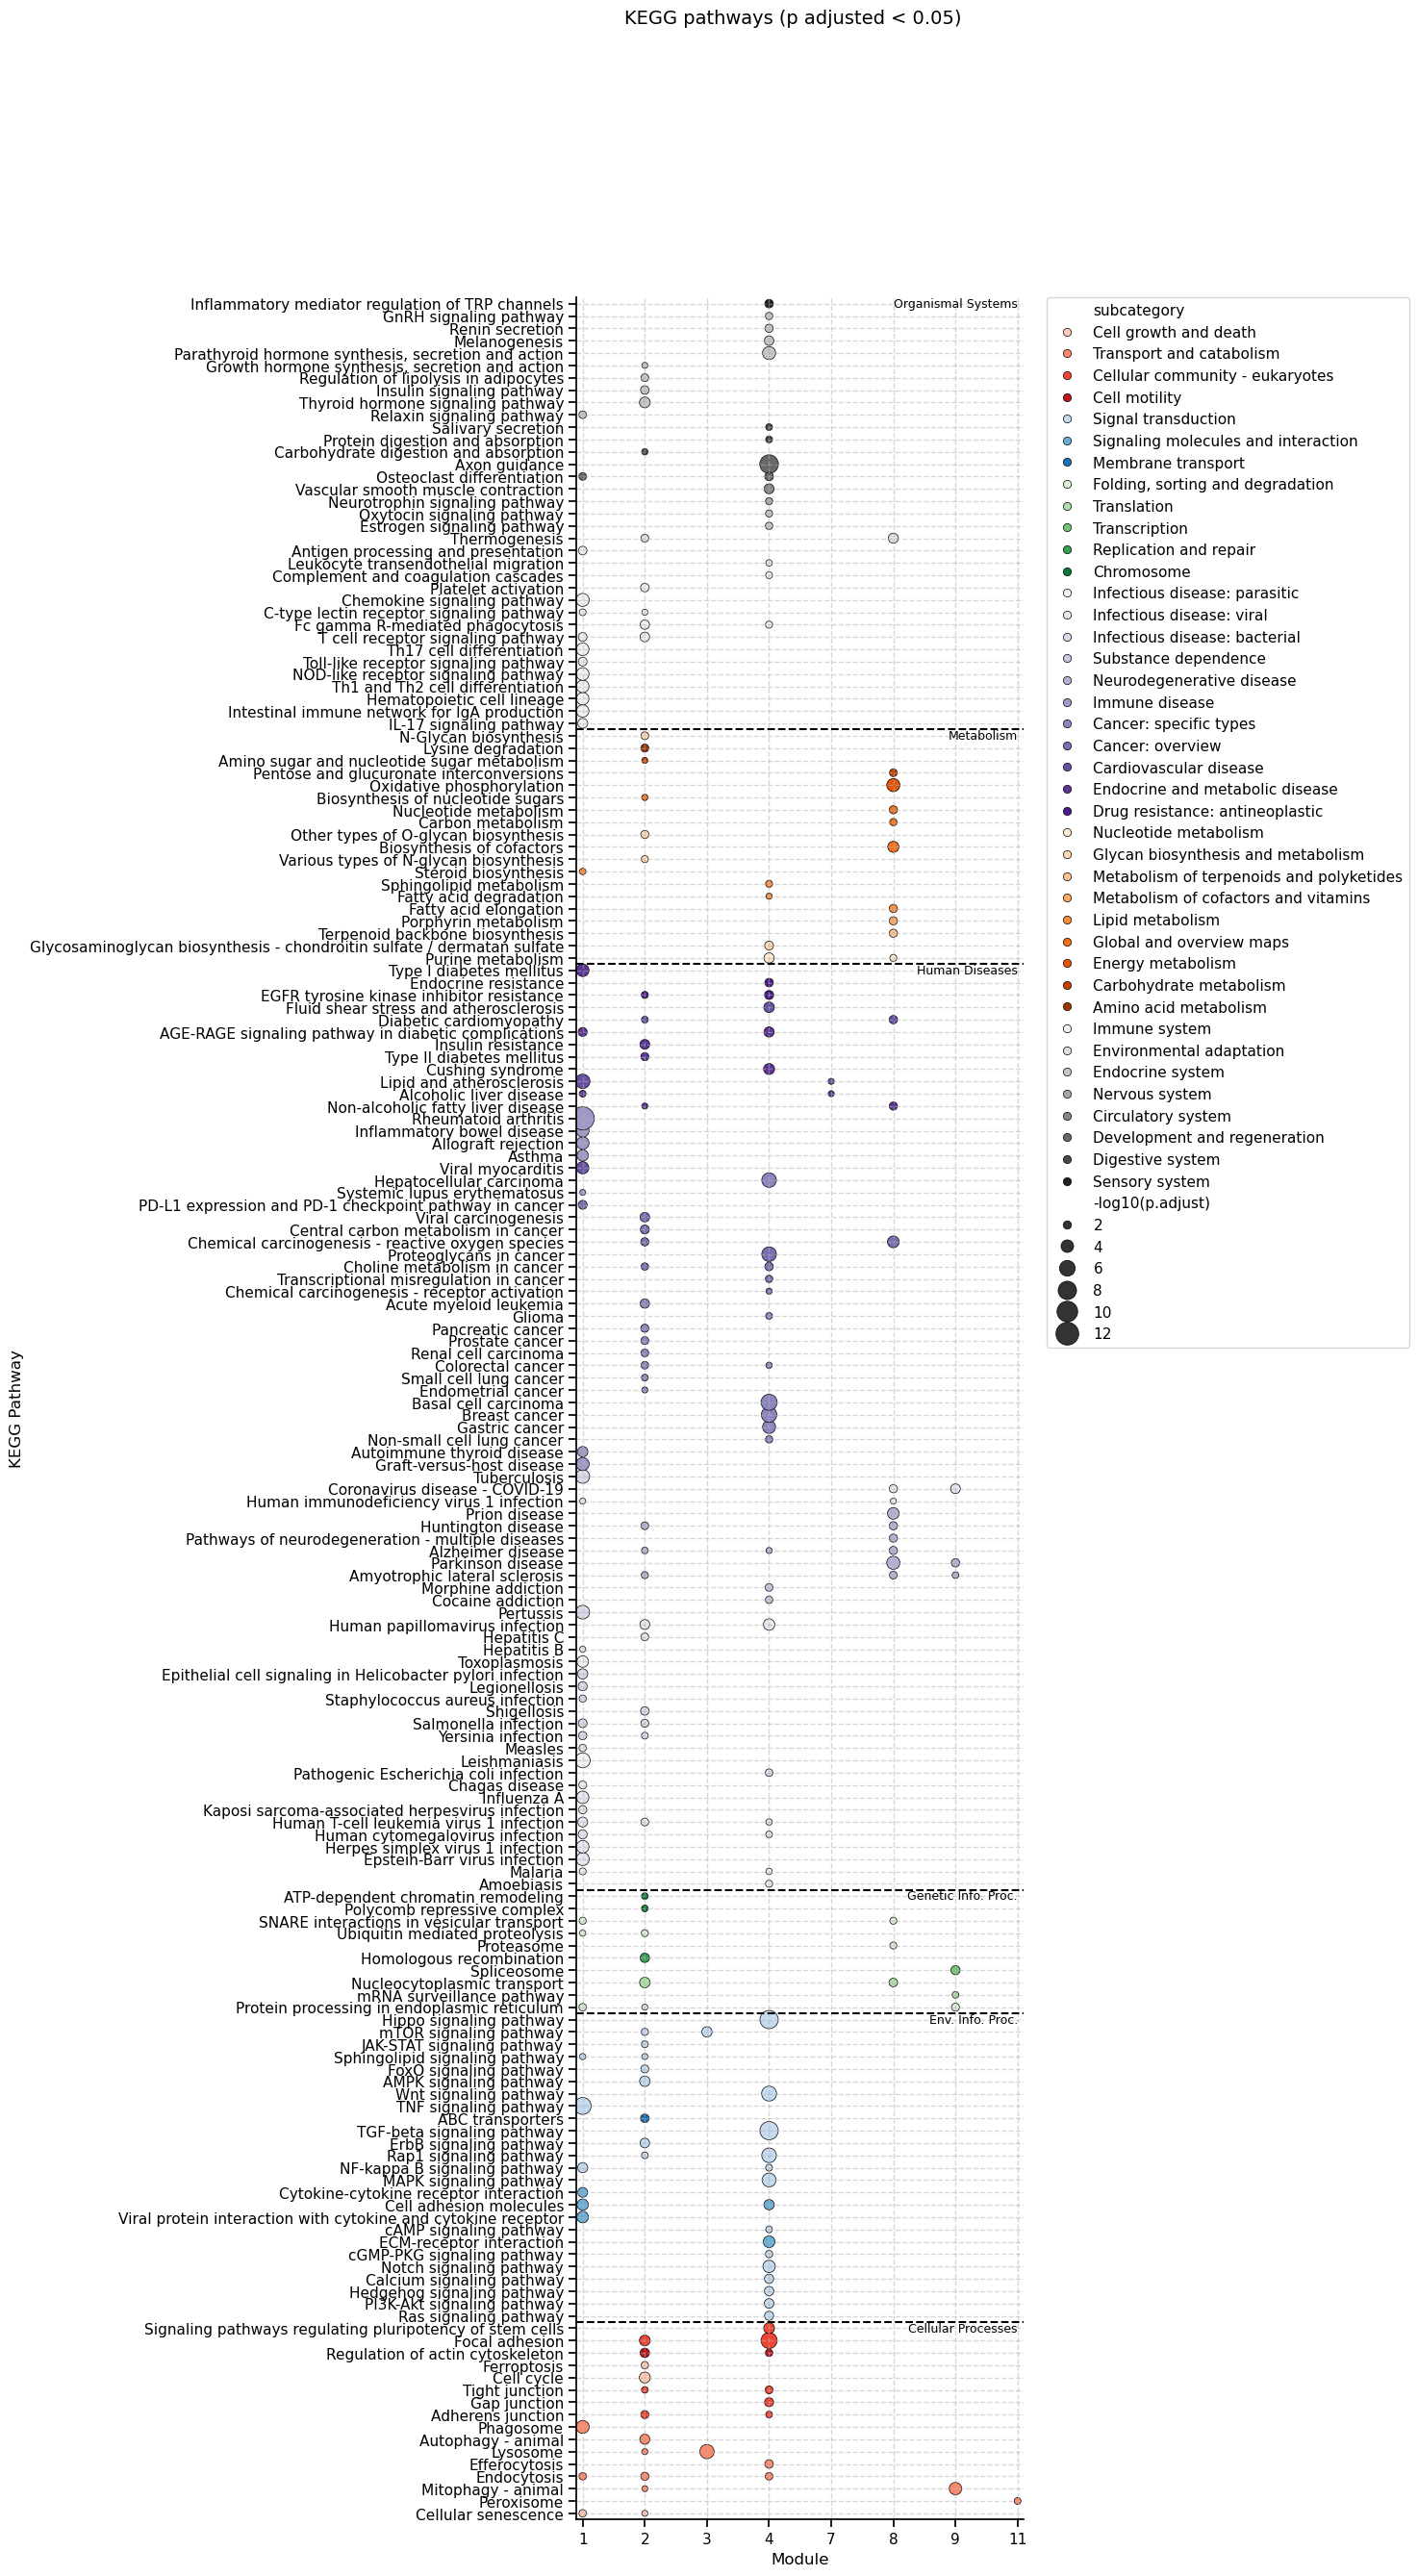

In [567]:
f, ax = plt.subplots(figsize=(6, 30))
g1 = sns.scatterplot(x='module_map', y='i', size='-log10(p.adjust)', sizes=(20, 300), data=kegg_alpaca_significant, hue='subcategory', palette=specific_palette, ax=ax, hue_order =specific_palette.keys(), alpha = 1, lw = .5, edgecolor='k')
# for the legend can you order the subcategories based on the category?
# draw row lines for each category with name on the side, you need to check how long each category is
maxx = len(map_nonnul_modules.keys())-2
for i in range(0, len(kegg_alpaca_significant)):
    temp = kegg_alpaca_significant[kegg_alpaca_significant['category'] == kegg_alpaca_significant.iloc[i]['category']]
    lrows = len(temp['i'].unique())
    if i == 0:
        ax.text(maxx+1, i+lrows -1 , kegg_alpaca_significant.iloc[i]['category'], fontsize=9, va='center', ha='right')
    else: 
        if kegg_alpaca_significant.iloc[i]['category'] != kegg_alpaca_significant.iloc[i-1]['category']:
            if kegg_alpaca_significant.iloc[i]['category']=='Environmental Information Processing':
                short = 'Env. Info. Proc.'
            elif kegg_alpaca_significant.iloc[i]['category']=='Genetic Information Processing':
                short = 'Genetic Info. Proc.'
            else:
                short = kegg_alpaca_significant.iloc[i]['category']

            ax.text(maxx+1, kegg_alpaca_significant.iloc[i]['i'] + lrows -1, short, fontsize=9, va='center', ha='right')
            ax.axhline(kegg_alpaca_significant.iloc[i]['i']-0.5, color='black', linestyle='--')
            
# legend outside
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('Module')
ax.set_ylabel('KEGG Pathway')
f.suptitle('KEGG pathways (p adjusted < 0.05)', fontsize=14)
# Show all xticks betwee 1 and 14
ax.set_xticks(range(0,len(kegg_alpaca_significant['module'].unique())))
# Use the module names as xticklabels
ax.set_xticklabels([str(i) for i in sorted(kegg_alpaca_significant['module'].unique())])

# Set yticks based on the Description column
ax.set_yticks(kegg_alpaca_significant['i'].unique())
ax.set_yticklabels(map_index.keys())
# Show all xticks
# adjust y limits
# add axis grid
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlim(-.1, len(map_nonnul_modules.keys())-0.9)
ax.set_ylim(-0.5, len(map_index)-0.5)
# despine
sns.despine()
plt.tight_layout()

f.savefig(outputDir + f'kegg_modules_all_s005.pdf', dpi=300, bbox_inches='tight')


In [690]:
# Can you do a plot where you count the number of significant pathways per module and per subcategorty?
kegg_alpaca_significant = kegg_alpaca[kegg_alpaca['p.adjust'] < 0.05]
kegg_alpaca_significant['subcategory'] = kegg_alpaca_significant['subcategory'].fillna('Other')
kegg_alpaca_significant['category'] = kegg_alpaca_significant['category'].fillna('Other')
kegg_alpaca_significant['subcategory'] = kegg_alpaca_significant['subcategory'].astype('str')
kegg_alpaca_significant['n_pathways'] = 1
kegg_alpaca_count = kegg_alpaca_significant.groupby(['module', 'subcategory']).agg({'n_pathways': 'sum'}).reset_index()
kegg_alpaca_count = kegg_alpaca_count.sort_values(by=['module', 'subcategory'])
kegg_alpaca_count['module'] = kegg_alpaca_count['module'].astype('str')
# map the subcategories to the categories
kegg_alpaca_count['category'] = kegg_alpaca_count['subcategory'].map(kegg_alpaca_significant.set_index('subcategory')['category'].to_dict())
kegg_alpaca_count.sort_values(by=['module', 'subcategory'], inplace=True)

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/843739742.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kegg_alpaca_significant['subcategory'] = kegg_alpaca_significant['subcategory'].fillna('Other')
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/843739742.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kegg_alpaca_significant['category'] = kegg_alpaca_significant['category'].fillna('Other')
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/8437397

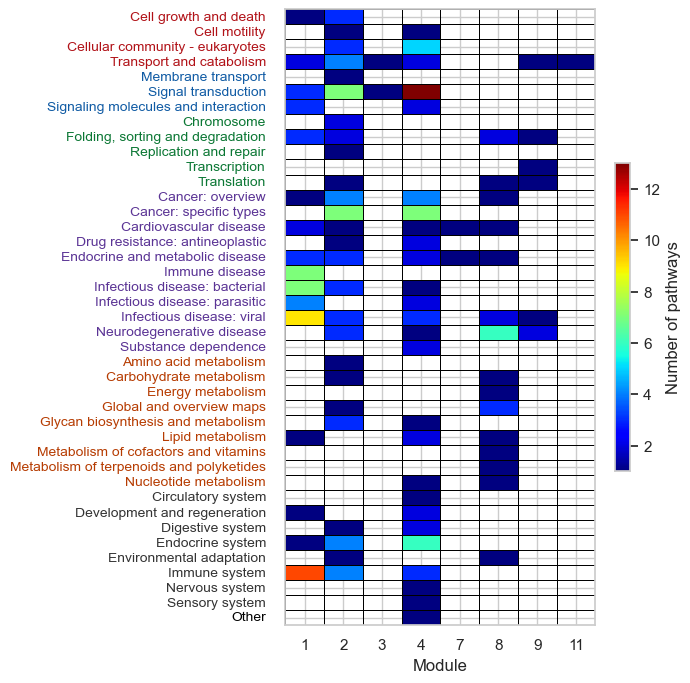

In [691]:
subdf = pd.pivot_table(kegg_alpaca_count.sort_values(by = ['category','module']), values='n_pathways', index='module', columns='subcategory', fill_value=0).T
subdf.columns = [int(i) for i in subdf.columns]
subdf = subdf.reindex(sorted(subdf.columns), axis=1)  # Sort columns alphabetically
# Order the rows by category
subdf = subdf.reindex(sorted(subdf.index, key=lambda x: kegg_alpaca_significant[kegg_alpaca_significant['subcategory'] == x]['category'].unique()[0]), axis=0)
# Make the colorbar smaller
f, ax = plt.subplots(figsize=(5, 8))
sns.heatmap(subdf, cmap='jet', cbar_kws={'label': 'Number of pathways', 'shrink':0.5}, linewidths=.5, linecolor='black', mask = (subdf==0))
ax.set_yticklabels([])
# Color the ytick labels with the category colors, use the category not the subcategory

for i, cat in enumerate(subdf.index):
    category = kegg_alpaca_significant.set_index('subcategory')['category'].to_dict()[cat]
    if category != 'Other':
        pal = whole_palette[category]
        color = sns.color_palette(pal, 5)[-1]
    else:
        color = 'k'
    if cat in specific_palette:
        ax.text(-0.5, i+0.5, cat, color=color, fontsize=10, va='center', ha='right')
    else:
        ax.text(-0.5, i+0.5, cat, color=color, fontsize=10, va='center', ha='right')

ax.set_ylabel("")
ax.set_xlabel("Module")

# add spines
sns.despine(left=False, bottom=False, right=False, top=False)

f.savefig(outputDir + 'kegg_modules_count.pdf', dpi=300, bbox_inches='tight')

## Comparison with DRAGON clusters

In [177]:
# import all functions from utils.py that is inside src folder
from src.utils import *

In [694]:
# Here you need the dragon files for each subtype
dragon_fn = {'cms1':'../../tcga-coad-subtype/results/batch-coad-subtype-20240510/tcga_coad_cms1/analysis/dragon/tcga_coad_cms1_dragon_mat.tsv',
             'cms2':'../../tcga-coad-subtype/results/batch-coad-subtype-20240510/tcga_coad_cms2/analysis/dragon/tcga_coad_cms2_dragon_mat.tsv',
             'cms3':'../../tcga-coad-subtype/results/batch-coad-subtype-20240510/tcga_coad_cms3/analysis/dragon/tcga_coad_cms3_dragon_mat.tsv',
             'cms4':'../../tcga-coad-subtype/results/batch-coad-subtype-20240510/tcga_coad_cms4/analysis/dragon/tcga_coad_cms4_dragon_mat.tsv'}
             

In [695]:
# Read the dragons with the function from utils.py
dragons = read_dragons(dragon_fn)

cms1
cms2
cms3
cms4


In [696]:
# to keep track of all the edges we will create a dataframe where subtypes are in the columns and rows are the edges
# For simplicity we write down the order of the subtypes
subtype_order = ['cms2','cms4']
dragon = get_long_dragon(dragons)
dragon.head()

                        level_0                 level_1        0
0        AC023509.3_methylation  AC092835.1_methylation     0.01
1        AC023509.3_methylation  AC138696.1_methylation   0.0016
2        AC023509.3_methylation       AEBP1_methylation  -0.0019
3        AC023509.3_methylation       AEBP2_methylation   0.0024
4        AC023509.3_methylation       AHDC1_methylation   0.0045
...                         ...                     ...      ...
1006066      ZSCAN22_expression         ZXDB_expression  0.00078
1006067      ZSCAN22_expression         ZXDC_expression   0.0039
1006068       ZSCAN9_expression         ZXDB_expression -0.00077
1006069       ZSCAN9_expression         ZXDC_expression  0.00077
1006070         ZXDB_expression         ZXDC_expression   0.0005

[1006071 rows x 3 columns]
                          node1                   node2     cms1
0        AC023509.3_methylation  AC092835.1_methylation     0.01
1        AC023509.3_methylation  AC138696.1_methylation   0.00

node1                   node2    cms1    cms2    cms3  \
0  AC023509.3_methylation  AC092835.1_methylation    0.01 -0.0024  -0.012   
1  AC023509.3_methylation  AC138696.1_methylation  0.0016  0.0082  0.0061   
2  AC023509.3_methylation        AEBP1_expression -0.0053  0.0023  0.0034   
3  AC023509.3_methylation       AEBP1_methylation -0.0019 -0.0043 0.00015   
4  AC023509.3_methylation        AEBP2_expression  0.0012  0.0016  0.0018   

     cms4  
0   0.011  
1  0.0045  
2 -0.0052  
3  0.0026  
4  0.0018

In [697]:
# mean dragon value for all subtypes
dragon['mean']  = dragon.loc[:,subtype_order].mean(axis =1)
# absolute mean dragon value for all subtypes
dragon['abs_mean']  = np.abs(dragon.loc[:,subtype_order]).mean(axis =1)
# variance
dragon['var']  = dragon.loc[:,subtype_order].var(axis =1)

# node type, whether expression or methylation
dragon['node1_type'] = [i.split('_')[1] for i in dragon['node1']]
dragon['node2_type'] = [i.split('_')[1] for i in dragon['node2']]
# node name
dragon['node1_tf'] = [i.split('_')[0] for i in dragon['node1']]
dragon['node2_tf'] = [i.split('_')[0] for i in dragon['node2']]

# get absolute values for dragons
dragon.loc[:,[i+'_abs' for i in subtype_order]] = np.abs(dragon.loc[:,subtype_order].values)

# edge name
dragon['edge'] = dragon.node1_tf +'-'+ dragon.node2_tf
dragon = dragon.set_index('edge')
# select same TF edges
dragon['same'] = 1*(dragon.node1_tf == dragon.node2_tf)
dragon.sort_values(by = 'mean', ascending = False)

node1               node2   cms1  cms2    cms3  \
edge                                                                         
ZNF646-ZNF668  ZNF646_methylation  ZNF668_methylation  0.055 0.066   0.053   
HOXA5-HOXA6     HOXA5_methylation   HOXA6_methylation  0.023 0.053   0.041   
ZNF41-ZNF674    ZNF41_methylation  ZNF674_methylation  0.036 0.048   0.043   
ELF4-ZNF81       ELF4_methylation   ZNF81_methylation  0.034 0.047   0.043   
ZNF41-ZNF81     ZNF41_methylation   ZNF81_methylation  0.035 0.047   0.043   
...                           ...                 ...    ...   ...     ...   
ZXDC-NFIB        ZXDC_methylation     NFIB_expression    NaN   NaN -0.0063   
ZXDC-RFX6        ZXDC_methylation     RFX6_expression    NaN   NaN   0.002   
ZXDC-RORA        ZXDC_methylation     RORA_expression 0.0048   NaN -0.0022   
ZXDC-SIX4        ZXDC_methylation     SIX4_expression    NaN   NaN -0.0009   
ZXDC-TBX21       ZXDC_methylation    TBX21_expression  0.002   NaN     NaN   

               cms4  mean  abs_mean     var   node1_type   node2_type  \
edge                                                                    
ZNF646-ZNF668 0.066 0.066     0.066 9.2e-09  methylation  methylation   
HOXA5-HOXA6    0.06 0.057     0.057 2.6e-05  methylation  methylation   
ZNF41-ZNF674  0.044 0.046     0.046 6.9e-06  methylation  methylation   
ELF4-ZNF81    0.044 0.046     0.046 3.7e-06  methylation  methylation   
ZNF41-ZNF81   0.044 0.046     0.046 4.5e-06  methylation  methylation   
...             ...   ...       ...     ...          ...          ...   
ZXDC-NFIB       NaN   NaN       NaN     NaN  methylation   expression   
ZXDC-RFX6       NaN   NaN       NaN     NaN  methylation   expression   
ZXDC-RORA       NaN   NaN       NaN     NaN  methylation   expression   
ZXDC-SIX4       NaN   NaN       NaN     NaN  methylation   expression   
ZXDC-TBX21      NaN   NaN       NaN     NaN  methylation   expression   

              node1_tf node2_tf  cms2_abs  cms4_abs  same  
edge                                                       
ZNF646-ZNF668   ZNF646   ZNF668     0.066     0.066     0  
HOXA5-HOXA6      HOXA5    HOXA6     0.053      0.06     0  
ZNF41-ZNF674     ZNF41   ZNF674     0.048     0.044     0  
ELF4-ZNF81        ELF4    ZNF81     0.047     0.044     0  
ZNF41-ZNF81      ZNF41    ZNF81     0.047     0.044     0  
...                ...      ...       ...       ...   ...  
ZXDC-NFIB         ZXDC     NFIB       NaN       NaN     0  
ZXDC-RFX6         ZXDC     RFX6       NaN       NaN     0  
ZXDC-RORA         ZXDC     RORA       NaN       NaN     0  
ZXDC-SIX4         ZXDC     SIX4       NaN       NaN     0  
ZXDC-TBX21        ZXDC    TBX21       NaN       NaN     0  

[1067100 rows x 16 columns]

In [698]:
# Get only methylation to expression edges
dragon_trans = dragon[(dragon.node1_type!=dragon.node2_type)]
dragon_trans.head()

node1              node2    cms1   cms2  \
edge                                                                          
AC023509.3-AEBP1   AC023509.3_methylation   AEBP1_expression -0.0053 0.0023   
AC023509.3-AEBP2   AC023509.3_methylation   AEBP2_expression  0.0012 0.0016   
AC023509.3-AHDC1   AC023509.3_methylation   AHDC1_expression -0.0024 -0.006   
AC023509.3-AHR     AC023509.3_methylation     AHR_expression     NaN    NaN   
AC023509.3-AKAP8L  AC023509.3_methylation  AKAP8L_expression -0.0012 0.0037   

                     cms3    cms4    mean  abs_mean     var   node1_type  \
edge                                                                       
AC023509.3-AEBP1   0.0034 -0.0052 -0.0015    0.0037 2.8e-05  methylation   
AC023509.3-AEBP2   0.0018  0.0018  0.0017    0.0017 2.6e-08  methylation   
AC023509.3-AHDC1  -0.0015 -0.0019 -0.0039    0.0039 8.5e-06  methylation   
AC023509.3-AHR    -0.0022     NaN     NaN       NaN     NaN  methylation   
AC023509.3-AKAP8L -0.0044  0.0057  0.0047    0.0047   2e-06  methylation   

                   node2_type    node1_tf node2_tf  cms2_abs  cms4_abs  same  
edge                                                                          
AC023509.3-AEBP1   expression  AC023509.3    AEBP1    0.0023    0.0052     0  
AC023509.3-AEBP2   expression  AC023509.3    AEBP2    0.0016    0.0018     0  
AC023509.3-AHDC1   expression  AC023509.3    AHDC1     0.006    0.0019     0  
AC023509.3-AHR     expression  AC023509.3      AHR       NaN       NaN     0  
AC023509.3-AKAP8L  expression  AC023509.3   AKAP8L    0.0037    0.0057     0

In [699]:
# Add binary label on whether the TFs are the same
sns.set_context('paper', font_scale = 1.5)
dragon_trans['same TF'] = (dragon_trans.node1_tf == dragon_trans.node2_tf)

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/2537370692.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_trans['same TF'] = (dragon_trans.node1_tf == dragon_trans.node2_tf)


In [700]:
dragon_direct = dragon_trans[dragon_trans['same TF']==True]
dragon_direct.head()

node1              node2    cms1    cms2    cms3  \
edge                                                                           
AEBP1-AEBP1     AEBP1_methylation   AEBP1_expression -0.0026  0.0009 -0.0021   
AEBP2-AEBP2     AEBP2_methylation   AEBP2_expression -0.0012  -0.018 -0.0052   
AHDC1-AHDC1     AHDC1_methylation   AHDC1_expression -0.0021 -0.0013 -0.0044   
AHR-AHR           AHR_methylation     AHR_expression     NaN     NaN -0.0074   
AKAP8L-AKAP8L  AKAP8L_methylation  AKAP8L_expression -0.0035  0.0011 -0.0015   

                  cms4     mean  abs_mean     var   node1_type  node2_type  \
edge                                                                         
AEBP1-AEBP1    0.00093  0.00091   0.00091 2.4e-10  methylation  expression   
AEBP2-AEBP2    -0.0073   -0.013     0.013   6e-05  methylation  expression   
AHDC1-AHDC1   -0.00084  -0.0011    0.0011 9.8e-08  methylation  expression   
AHR-AHR            NaN      NaN       NaN     NaN  methylation  expression   
AKAP8L-AKAP8L   -0.003 -0.00096     0.002 8.3e-06  methylation  expression   

              node1_tf node2_tf  cms2_abs  cms4_abs  same  same TF  
edge                                                                
AEBP1-AEBP1      AEBP1    AEBP1    0.0009   0.00093     1     True  
AEBP2-AEBP2      AEBP2    AEBP2     0.018    0.0073     1     True  
AHDC1-AHDC1      AHDC1    AHDC1    0.0013   0.00084     1     True  
AHR-AHR            AHR      AHR       NaN       NaN     1     True  
AKAP8L-AKAP8L   AKAP8L   AKAP8L    0.0011     0.003     1     True

In [701]:
th = 0.1 #quantile threshold

for key in subtype_order:
    threshold = dragon_direct[key].dropna().quantile(th)
    print(key, threshold)
    dragon_direct[key+'_lower'] = dragon_direct[key] < threshold
dragon_direct['lower'] = np.sum(dragon_direct.loc[:,[key+'_lower' for key in subtype_order]], axis = 1)
dragon_direct.sort_values(by = 'lower', ascending = True)


cms2 -0.01590839262254296
cms4 -0.01560371809056855


/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/2059425291.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_direct[key+'_lower'] = dragon_direct[key] < threshold
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/2059425291.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_direct[key+'_lower'] = dragon_direct[key] < threshold
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/2059425291.py:7: SettingWithCopyWarning: 
A value is trying to be set

node1              node2    cms1    cms2     cms3  \
edge                                                                            
AEBP1-AEBP1     AEBP1_methylation   AEBP1_expression -0.0026  0.0009  -0.0021   
TFDP1-TFDP1     TFDP1_methylation   TFDP1_expression -0.0051   0.002   0.0031   
TFEC-TFEC        TFEC_methylation    TFEC_expression 0.00036 -0.0054 -0.00056   
TGIF2-TGIF2     TGIF2_methylation   TGIF2_expression  -0.002 -0.0079  -0.0071   
THAP11-THAP11  THAP11_methylation  THAP11_expression 4.6e-05 -0.0032  -0.0014   
...                           ...                ...     ...     ...      ...   
HMGA1-HMGA1     HMGA1_methylation   HMGA1_expression -0.0016  -0.026  -0.0096   
ZNF28-ZNF28     ZNF28_methylation   ZNF28_expression  -0.013  -0.025   -0.015   
ZNF532-ZNF532  ZNF532_methylation  ZNF532_expression -0.0093  -0.022   -0.011   
STAT5A-STAT5A  STAT5A_methylation  STAT5A_expression  -0.015  -0.024   -0.015   
ZNF329-ZNF329  ZNF329_methylation  ZNF329_expression  -0.015   -0.02   -0.013   

                 cms4     mean  abs_mean     var   node1_type  node2_type  \
edge                                                                        
AEBP1-AEBP1   0.00093  0.00091   0.00091 2.4e-10  methylation  expression   
TFDP1-TFDP1    -0.005  -0.0015    0.0035 2.4e-05  methylation  expression   
TFEC-TFEC      0.0018  -0.0018    0.0036 2.6e-05  methylation  expression   
TGIF2-TGIF2    0.0063 -0.00083    0.0071  0.0001  methylation  expression   
THAP11-THAP11 -0.0011  -0.0022    0.0022 2.2e-06  methylation  expression   
...               ...      ...       ...     ...          ...         ...   
HMGA1-HMGA1    -0.016   -0.021     0.021 5.4e-05  methylation  expression   
ZNF28-ZNF28    -0.033   -0.029     0.029 2.6e-05  methylation  expression   
ZNF532-ZNF532  -0.016   -0.019     0.019 1.6e-05  methylation  expression   
STAT5A-STAT5A   -0.02   -0.022     0.022 9.6e-06  methylation  expression   
ZNF329-ZNF329  -0.023   -0.022     0.022 5.6e-06  methylation  expression   

              node1_tf node2_tf  cms2_abs  cms4_abs  same  same TF  \
edge                                                                 
AEBP1-AEBP1      AEBP1    AEBP1    0.0009   0.00093     1     True   
TFDP1-TFDP1      TFDP1    TFDP1     0.002     0.005     1     True   
TFEC-TFEC         TFEC     TFEC    0.0054    0.0018     1     True   
TGIF2-TGIF2      TGIF2    TGIF2    0.0079    0.0063     1     True   
THAP11-THAP11   THAP11   THAP11    0.0032    0.0011     1     True   
...                ...      ...       ...       ...   ...      ...   
HMGA1-HMGA1      HMGA1    HMGA1     0.026     0.016     1     True   
ZNF28-ZNF28      ZNF28    ZNF28     0.025     0.033     1     True   
ZNF532-ZNF532   ZNF532   ZNF532     0.022     0.016     1     True   
STAT5A-STAT5A   STAT5A   STAT5A     0.024      0.02     1     True   
ZNF329-ZNF329   ZNF329   ZNF329      0.02     0.023     1     True   

               cms2_lower  cms4_lower  lower  
edge                                          
AEBP1-AEBP1         False       False      0  
TFDP1-TFDP1         False       False      0  
TFEC-TFEC           False       False      0  
TGIF2-TGIF2         False       False      0  
THAP11-THAP11       False       False      0  
...                   ...         ...    ...  
HMGA1-HMGA1          True        True      2  
ZNF28-ZNF28          True        True      2  
ZNF532-ZNF532        True        True      2  
STAT5A-STAT5A        True        True      2  
ZNF329-ZNF329        True        True      2  

[656 rows x 20 columns]

In [702]:
# Overlap the two analyses
membership_dragon = membership_tf.merge(dragon_direct, left_on='node_name', right_on='node1_tf', how = 'inner')
membership_dragon

node  module  modularity node_name node_type gene_symbol  n_tf  \
0       ALX3_A       2       0.011      ALX3         A        ALX3   243   
1         AR_A       2      0.0014        AR         A          AR   243   
2     ARID3A_A       1      0.0051    ARID3A         A      ARID3A   251   
3        ARX_A       2       0.006       ARX         A         ARX   243   
4      ASCL2_A       4      0.0033     ASCL2         A       ASCL2   267   
..         ...     ...         ...       ...       ...         ...   ...   
415   ZNF860_A       4      0.0073    ZNF860         A      ZNF860   267   
416   ZNF880_A       4       0.011    ZNF880         A      ZNF880   267   
417  ZSCAN16_A       4     0.00067   ZSCAN16         A     ZSCAN16   267   
418  ZSCAN22_A       4      0.0048   ZSCAN22         A     ZSCAN22   267   
419   ZSCAN9_A       1      0.0028    ZSCAN9         A      ZSCAN9   251   

     raw_modularity                node1               node2  ...  node2_type  \
0               2.7     ALX3_methylation     ALX3_expression  ...  expression   
1              0.35       AR_methylation       AR_expression  ...  expression   
2               1.3   ARID3A_methylation   ARID3A_expression  ...  expression   
3               1.5      ARX_methylation      ARX_expression  ...  expression   
4              0.87    ASCL2_methylation    ASCL2_expression  ...  expression   
..              ...                  ...                 ...  ...         ...   
415               2   ZNF860_methylation   ZNF860_expression  ...  expression   
416             2.8   ZNF880_methylation   ZNF880_expression  ...  expression   
417            0.18  ZSCAN16_methylation  ZSCAN16_expression  ...  expression   
418             1.3  ZSCAN22_methylation  ZSCAN22_expression  ...  expression   
419             0.7   ZSCAN9_methylation   ZSCAN9_expression  ...  expression   

     node1_tf  node2_tf  cms2_abs  cms4_abs  same  same TF cms2_lower  \
0        ALX3      ALX3    0.0059    0.0047     1     True      False   
1          AR        AR     0.011    0.0039     1     True      False   
2      ARID3A    ARID3A    0.0026    0.0014     1     True      False   
3         ARX       ARX       NaN       NaN     1     True      False   
4       ASCL2     ASCL2     0.012    0.0047     1     True      False   
..        ...       ...       ...       ...   ...      ...        ...   
415    ZNF860    ZNF860     0.004    0.0095     1     True      False   
416    ZNF880    ZNF880     0.034     0.027     1     True       True   
417   ZSCAN16   ZSCAN16   3.7e-05    0.0068     1     True      False   
418   ZSCAN22   ZSCAN22    0.0085     0.012     1     True      False   
419    ZSCAN9    ZSCAN9     0.002   0.00014     1     True      False   

    cms4_lower lower  
0        False     0  
1        False     0  
2        False     0  
3        False     0  
4        False     0  
..         ...   ...  
415      False     0  
416       True     2  
417      False     0  
418      False     0  
419      False     0  

[420 rows x 28 columns]

In [705]:
mapped_dragon = membership_tf.loc[:,['module','node_name']].groupby('module').count().merge(all, left_index=True, right_index=True)
mapped_dragon['mapped_in_dragon'] =  mapped_dragon['total_tf']/mapped_dragon['node_name_x']
mapped_dragon

node_name_x  module  node_name_y  total_tf  mapped_in_dragon  \
1           251       2          243        98              0.39   
2           243       3           17        11             0.045   
3            17       4          267       111               6.5   
4           267       5           29        16              0.06   
5            29       6           32        14              0.48   
6            32       7           20        10              0.31   
7            20       8           59        20                 1   
8            59       9           40        17              0.29   
9            40      10            3         3             0.075   
10            3      11            6         2              0.67   
11            6      12           22        10               1.7   
12           22      13            7         2             0.091   
13            7      14            1         1              0.14   

    node1_tf_lower  node1_tf_cms2_lower  node1_tf_cms4_lower  \
1               12                    9                   11   
2                1                  NaN                    1   
3               21                   14                   18   
4                2                    1                    2   
5                1                    1                    1   
6              NaN                  NaN                  NaN   
7                2                    1                    2   
8              NaN                  NaN                  NaN   
9              NaN                  NaN                  NaN   
10               2                    2                  NaN   
11               1                  NaN                    1   
12             NaN                  NaN                  NaN   
13             NaN                  NaN                  NaN   

    percentage_lower  percentage_lower_cms2  percentage_lower_cms4  \
1                 12                    9.2                     11   
2                9.1                    NaN                    9.1   
3                 19                     13                     16   
4                 12                    6.2                     12   
5                7.1                    7.1                    7.1   
6                NaN                    NaN                    NaN   
7                 10                      5                     10   
8                NaN                    NaN                    NaN   
9                NaN                    NaN                    NaN   
10             1e+02                  1e+02                    NaN   
11                10                    NaN                     10   
12               NaN                    NaN                    NaN   
13               NaN                    NaN                    NaN   

            numbers  lower_of_all  
1    12/98 (12.24%)         0.049  
2      1/11 (9.09%)         0.059  
3   21/111 (18.92%)         0.079  
4      2/16 (12.5%)         0.069  
5      1/14 (7.14%)         0.031  
6       0/10 (0.0%)           NaN  
7      2/20 (10.0%)         0.034  
8       0/17 (0.0%)           NaN  
9        0/3 (0.0%)           NaN  
10     2/2 (100.0%)          0.33  
11     1/10 (10.0%)         0.045  
12       0/2 (0.0%)           NaN  
13       0/1 (0.0%)           NaN

In [706]:
# Count how many TF are silenced in each module
all = membership_dragon.loc[:,['module','node1_tf']].groupby('module').count()

lower = membership_dragon.loc[membership_dragon['lower']>0,:].loc[:,['module','node1_tf']].groupby('module').count()
lower_cms2 = membership_dragon.loc[membership_dragon['cms2_lower']==True,:].loc[:,['module','node1_tf']].groupby('module').count()
lower_cms4 = membership_dragon.loc[membership_dragon['cms4_lower']==True,:].loc[:,['module','node1_tf']].groupby('module').count()
# rename lower cms2 and lower cms4 column
all.columns = ['total_tf']
all = membership_tf.loc[:,['module','node_name']].groupby('module').count().merge(all, left_index=True, right_index=True)
all['mapped_in_dragon'] =  all['total_tf']/all['node_name']

lower.columns = ['node1_tf_lower']
lower_cms2.columns = ['node1_tf_cms2_lower']
lower_cms4.columns = ['node1_tf_cms4_lower']
# merge all lower counts
lower_cms2

node1_tf_cms2_lower
module                     
1                         9
2                         9
4                        14
5                         1
6                         1
8                         1
11                        2

In [707]:
all = all.merge(lower, left_index=True, right_index=True, how = 'left')
all = all.merge(lower_cms2, left_index=True, right_index=True, how='left')
all = all.merge(lower_cms4, left_index=True, right_index=True, how='left')
all['percentage_lower'] = all['node1_tf_lower'] / all['total_tf'] * 100
all = all.reset_index()
all

module  node_name  total_tf  mapped_in_dragon  node1_tf_lower  \
0        1        251       105              0.42              11   
1        2        243        98               0.4              12   
2        3         17        11              0.65               1   
3        4        267       111              0.42              21   
4        5         29        16              0.55               2   
5        6         32        14              0.44               1   
6        7         20        10               0.5             NaN   
7        8         59        20              0.34               2   
8        9         40        17              0.42             NaN   
9       10          3         3                 1             NaN   
10      11          6         2              0.33               2   
11      12         22        10              0.45               1   
12      13          7         2              0.29             NaN   
13      14          1         1                 1             NaN   

    node1_tf_cms2_lower  node1_tf_cms4_lower  percentage_lower  
0                     9                    8                10  
1                     9                   11                12  
2                   NaN                    1               9.1  
3                    14                   18                19  
4                     1                    2                12  
5                     1                    1               7.1  
6                   NaN                  NaN               NaN  
7                     1                    2                10  
8                   NaN                  NaN               NaN  
9                   NaN                  NaN               NaN  
10                    2                  NaN             1e+02  
11                  NaN                    1                10  
12                  NaN                  NaN               NaN  
13                  NaN                  NaN               NaN

In [708]:
all['percentage_lower_cms2'] = all['node1_tf_cms2_lower'] / all['total_tf'] * 100
all['percentage_lower_cms4'] = all['node1_tf_cms4_lower'] / all['total_tf'] * 100

In [709]:
all['lower_of_all'] = all['percentage_lower']/100 * all['mapped_in_dragon']

In [711]:
all['numbers'] = all['node1_tf_lower'].fillna(0).astype(int).astype(str) + '/' + all['total_tf'].astype(int).astype(str) + ' (' + all['percentage_lower'].fillna(0).round(2).astype(str) + '%)'
number_tf_map = all.set_index('module')['numbers'].to_dict()

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/2016645169.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'Module {i+1}' for i in ax.get_yticks()])


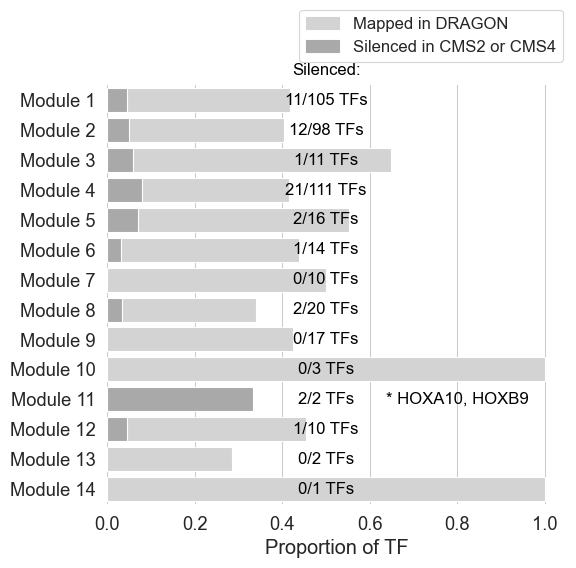

In [712]:
from matplotlib.patches import Patch
f, ax = plt.subplots(figsize=(6, 6))
lightgray = '#D3D3D3'
darkdarkgray = '#A9A9A9'
sns.barplot(y='module', x='mapped_in_dragon', data=all, color = lightgray, orient='h', ax = ax)
sns.barplot(y='module', x='lower_of_all', data=all, color = darkdarkgray, orient='h', ax = ax)
# create a legend with the two colors (lightblue and salmon), I need the colors
legend_elements = [Patch(facecolor=lightgray, edgecolor=lightgray, label='Mapped in DRAGON'),
                   Patch(facecolor=darkdarkgray, edgecolor=darkdarkgray, label='Silenced in CMS2 or CMS4')]
plt.legend(handles=legend_elements, loc='upper left', frameon=True, bbox_to_anchor=(0.4, 1.2), fontsize=12)
plt.ylabel('')
plt.xlabel('Proportion of TF')

ax.set_yticklabels([f'Module {i+1}' for i in ax.get_yticks()])

plt.text(0.5, -1 , 'Silenced:', fontsize=12, va='center', ha='center', color='Black', rotation=0)

for i in range(len(all)):
    module = all.iloc[i]['module']
    n_tfs = all.iloc[i]['total_tf']
    if n_tfs>0:
        annot = all.iloc[i]['numbers']
        annot = annot.split('(')[0] + 'TFs'
        plt.text(0.5, i ,annot , fontsize=12, va='center', ha='center', color='Black', rotation=0)
        if module == 11:
            plt.text(0.8, i , '* HOXA10, HOXB9', fontsize=12, va='center', ha='center', color='Black', rotation=0)



# Despine
sns.despine(left=True, bottom=True)

plt.tight_layout()


plt.show()  


In [713]:
ttt4 = membership_dragon.loc[:,['module','cms4','raw_modularity']]
ttt4['subtype'] = 'cms4'
ttt4 = ttt4.rename(columns={'cms4': 'dragon'})

ttt2 = membership_dragon.loc[:,['module','cms2','raw_modularity']]
ttt2['subtype'] = 'cms2'
ttt2 = ttt2.rename(columns={'cms2': 'dragon'})

ttt = pd.concat([ttt2, ttt4], axis=0)


In [714]:
membership_dragon['cms2-cms4'] = membership_dragon['cms2'] - membership_dragon['cms4']
membership_dragon['lower_cms2_cms4'] = 2*membership_dragon['cms2_lower']+1*membership_dragon['cms4_lower']
membership_dragon['lower_cms2_cms4']  = membership_dragon['lower_cms2_cms4'].map({0:'none', 1:'cms4', 2:'cms2', 3:'both'})

In [715]:
l2 = membership_dragon[membership_dragon['lower']>0].loc[:,['module','node1_tf','cms2','cms2_lower','lower_cms2_cms4']].reset_index()
l2.columns = ['index', 'module', 'node1_tf', 'DRAGON M-E', 'islower', 'lower_cms2_cms4']
l2['subtype'] = 'cms2'

l4 = membership_dragon[membership_dragon['lower']>0].loc[:,['module','node1_tf','cms4','cms4_lower','lower_cms2_cms4']].reset_index()
l4.columns = ['index', 'module', 'node1_tf', 'DRAGON M-E', 'islower', 'lower_cms2_cms4']
l4['subtype'] = 'cms4'

lll = pd.concat([l2, l4], axis=0)
lll

index  module node1_tf  DRAGON M-E  islower lower_cms2_cms4 subtype
0      10       2     BATF      -0.034     True            both    cms2
1      24       5  CENPBD1      -0.026     True            both    cms2
2      27       6  CREB3L1      -0.027     True            both    cms2
3      32       5    CXXC5      -0.014    False            cms4    cms2
4      68       1    FOXC2         NaN    False            cms4    cms2
..    ...     ...      ...         ...      ...             ...     ...
48    390       4   ZNF605       -0.02     True            cms4    cms4
49    399       4   ZNF704      -0.013    False            cms2    cms4
50    408       4   ZNF785      -0.022     True            both    cms4
51    410       1     ZNF8       -0.01    False            cms2    cms4
52    416       4   ZNF880      -0.027     True            both    cms4

[106 rows x 7 columns]

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_55662/968387945.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = 'DRAGON M-E', y = 'node1_tf', data = lll.reset_index(), hue = 'subtype', ax = ax, palette=sns.color_palette(['#1f77b4', '#d62728']), hue_order=['cms2', 'cms4'], alpha = 1, dodge=True, ci=None)


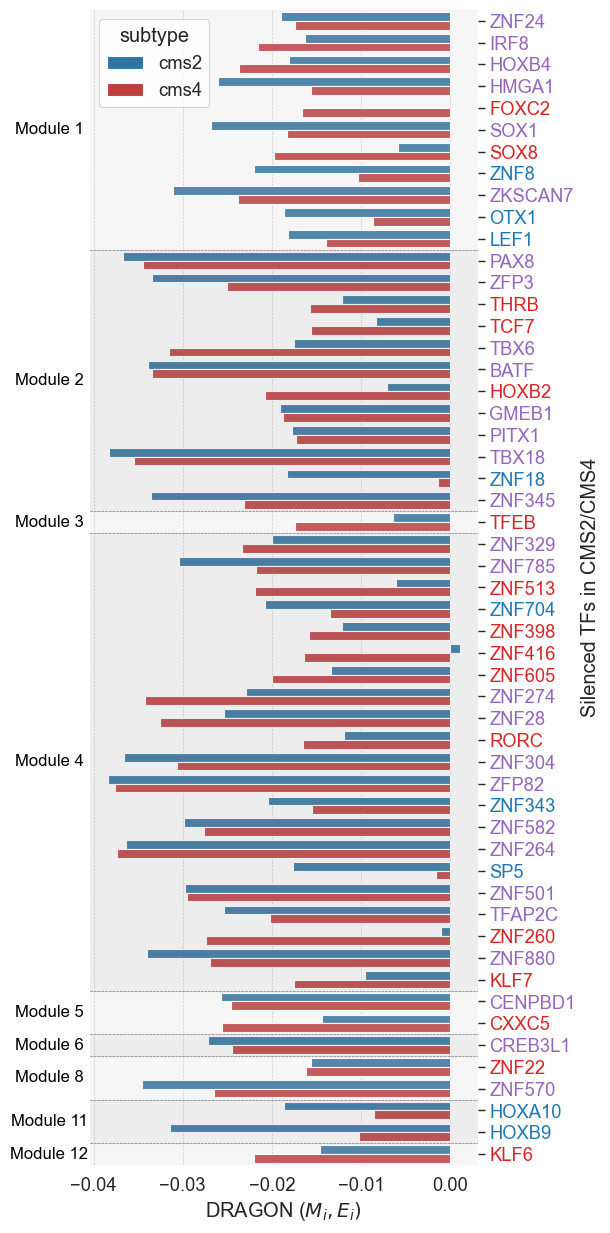

In [716]:
lll = lll.sort_values('module')
f, ax = plt.subplots(figsize=(5,15))
pal = sns.color_palette(['#808080', '#1f77b4', '#d62728', '#9467bd'])

ax.grid(axis = 'x', linestyle='--', linewidth=0.5)

sns.barplot(x = 'DRAGON M-E', y = 'node1_tf', data = lll.reset_index(), hue = 'subtype', ax = ax, palette=sns.color_palette(['#1f77b4', '#d62728']), hue_order=['cms2', 'cms4'], alpha = 1, dodge=True, ci=None)
# add horizontal lines for each module, you need to count how many TFs are in each module, because they need to separate
# the bars
total = 0
for i, module in enumerate(lll['module'].unique()):
    n_tfs = len(lll[lll['module']==module])/2
    total = total + n_tfs
    plt.axhline(y=total-0.5, color='gray', linestyle='--', linewidth=0.5)
    # chose a dark gray color for the module label
    plt.text(-0.045, total-n_tfs/2-0.5, f'Module {module}', fontsize=12, va='center', ha='center', color='Black', rotation = 0)

# Can you swap the ytick labels to be on the right side of the plot?
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
        
# Color the yticklabels based on lower_cms2_cms4
for i, label in enumerate(ax.get_yticklabels()):
    a = lll[lll['node1_tf'] == label.get_text()]['lower_cms2_cms4']
    if a.iloc[0] == 'cms2':
        label.set_color('#1f77b4')
    elif a.iloc[0] == 'cms4':
        label.set_color('#d62728')
    elif a.iloc[0] == 'both':
        label.set_color('#9467bd')
    else:
        label.set_color('gray')

# Despine the axes
sns.despine(ax=ax, left=True, bottom=True)

# Can you color the module background alternating dark and light gray?
total = 0
for i, module in enumerate(lll['module'].unique()):
    n_tfs = len(lll[lll['module']==module])/2
    total = total + n_tfs
    if i % 2 == 0:
        ax.add_patch(plt.Rectangle((-0.05, total-n_tfs-0.5), 1.05, n_tfs, color='lightgray', alpha=0.2))
    else:
        ax.add_patch(plt.Rectangle((-0.05, total-n_tfs-0.5), 1.05, n_tfs, color='darkgray', alpha=0.2))

ax.set_ylabel('Silenced TFs in CMS2/CMS4')
ax.set_xlabel('DRAGON ($M_i,E_i)$')
f.savefig(outputDir + 'dragon_tf_silenced.pdf', dpi=300, bbox_inches='tight')